In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from pathlib import Path
import os, json
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA



In [2]:
def find_stats_json_files(base_dir):
    """Recursively find all system stats JSONL files under base_dir."""
    #base_dir = os.path.expanduser(base_dir)
    stats_jsons = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.startswith("stats_") and file.endswith(".json"):
                full_path = os.path.join(root, file)
                stats_jsons.append(full_path)
    return stats_jsons

def parse_path_fields(path):
    parts = path.split(os.sep)
    #print(f"[DEBUG] parts: {parts}")
    filename = Path(path).name     # sys_stats_<port>_R<run>.jsonl
    stem = Path(filename).stem     # sys_stats_<port>_R<run>
    
    run = None
    for part in stem.split("_"):
        if part.startswith("R") and part[1:].isdigit():
            run = int(part[1:])
            break

    for i, p in enumerate(parts):
        #if p in ("mini-apps", "iperf"):
        if p in ("iperf", "mini-apps"):
            return {
                "app": p,
                #"date": parts[i+1],
                "proxy": parts[i+1],
                "congestion": parts[i+2],
                "parallel": parts[i+3],
                "duration": parts[i+4],
                "run": run
            }
    raise ValueError(f"Path {path} does not match expected pattern.")

def load_all_stats(base_dir):
    records = []
    for filepath in find_stats_json_files(base_dir):
        fields = parse_path_fields(filepath)
        with open(filepath) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except Exception:
                    continue
                if "timestamp" not in rec:
                    continue
                row = {**fields, **rec}
                records.append(row)
    return pd.DataFrame(records)


In [ ]:

#BASE_DIR = Path("~/Projects/chameleon/experiments/mini-apps")
BASE_DIR = Path("~/Projects/chameleon/EXPS/cons").expanduser()
df = load_all_stats(BASE_DIR)
#print(f"\n[INFO] Final DataFrame shape: {df.head(5)}{df.shape}")
#print(df.columns)
#print(df.sample(3))
df.to_pickle("data/df.pkl")
df.to_csv("data/df.csv", index=False)

In [3]:
df = pd.read_pickle("my_large_df.pkl")

In [4]:
def top_n_by_duration(group):
    # Extract N from duration,  "T10": 10
    n = int(group['duration'].iloc[0][1:])  # T10, T20, etc.
    return group.head(n)

# sort them by the net_rx_Gbps in descending order
df_sorted = df.sort_values(
    ["app", "proxy", "congestion", "parallel", "duration", "run", "net_rx_Gbps"], 
    #["app", "date", "proxy", "congestion", "flow", "duration", "run", "net_rx_Gbps"], 
    ascending=[True, True, True, True, True, True, False]
)

In [5]:
# FOR NET_RX which is based on cons
#df["net_rx_Gbps"] = pd.to_numeric(df["net_rx_Gbps"], errors="coerce")

# just extract the top N rows per group (change it based on the duration instead of top10)
topN_per_group = (
    df_sorted.groupby(
        ["app", "proxy", "congestion", "parallel", "duration", "run"], group_keys=False
    ).apply(top_n_by_duration)
    .reset_index(drop=True)
)

# groups by the values in each file
group_cols = ['app', 'proxy', 'congestion', 'parallel', 'duration', 'run']
agg_df = (
    topN_per_group
    .groupby(group_cols)
    .agg(
        avg_net_rx_Gbps=('net_rx_Gbps', 'mean'),
        avg_net_tx_Gbps=('net_tx_Gbps', 'mean'),
        max_total_cpu=('total_cpu', 'max'),
        mean_total_cpu=('total_cpu', 'mean'),
        sum_disk_read_MB=('disk_read_MB', 'sum'),
        sum_disk_write_MB=('disk_write_MB', 'sum'),
        sum_total_rx_dropped=('total_rx_dropped', 'sum'),
        sum_total_tx_dropped=('total_tx_dropped', 'sum')
    )
    .reset_index()
)

pd.set_option('display.max_columns', None)

# group by the sum/average of each value based on the run!
group_config_cols = ['app', 'proxy', 'congestion', 'parallel', 'duration']

agg_config_df = (
    agg_df
    .groupby(group_config_cols)
    .agg(
        avg_net_rx_Gbps=('avg_net_rx_Gbps', 'mean'),
        avg_net_tx_Gbps=('avg_net_tx_Gbps', 'mean'),
        max_total_cpu=('max_total_cpu', 'max'),
        mean_total_cpu=('mean_total_cpu', 'mean'),
        sum_disk_read_MB=('sum_disk_read_MB', 'sum'),
        sum_disk_write_MB=('sum_disk_write_MB', 'sum'),
        sum_total_rx_dropped=('sum_total_rx_dropped', 'sum'),
        sum_total_tx_dropped=('sum_total_tx_dropped', 'sum')
    )
    .reset_index()
)

pd.set_option('display.max_columns', None)


/tmp/ipykernel_3867587/4092408239.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(top_n_by_duration)


In [7]:
#print(topN_per_group.sample(15))
#print(topN_per_group.head(15))
#print(f"[INFO] TopN-per-group DataFrame shape: {topN_per_group.shape}")

#print(agg_df.head(11))  # or iloc if you want exactly the first 10
#print(group_cols)
#print(f"[INFO] agg_config_df shape: {agg_df.shape}")

#print(agg_config_df.head(10))
#print(f"[INFO] agg_config_df shape: {agg_config_df.shape}")

In [6]:
apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()
parallels = sorted(agg_config_df["parallel"].unique(), key=lambda x: int(x[1:]))
durations = sorted(agg_config_df["duration"].unique(), key=lambda x: int(x[1:]))
#runs = sorted(agg_config_df["run"].unique(), key=lambda x: int(x[1:]))

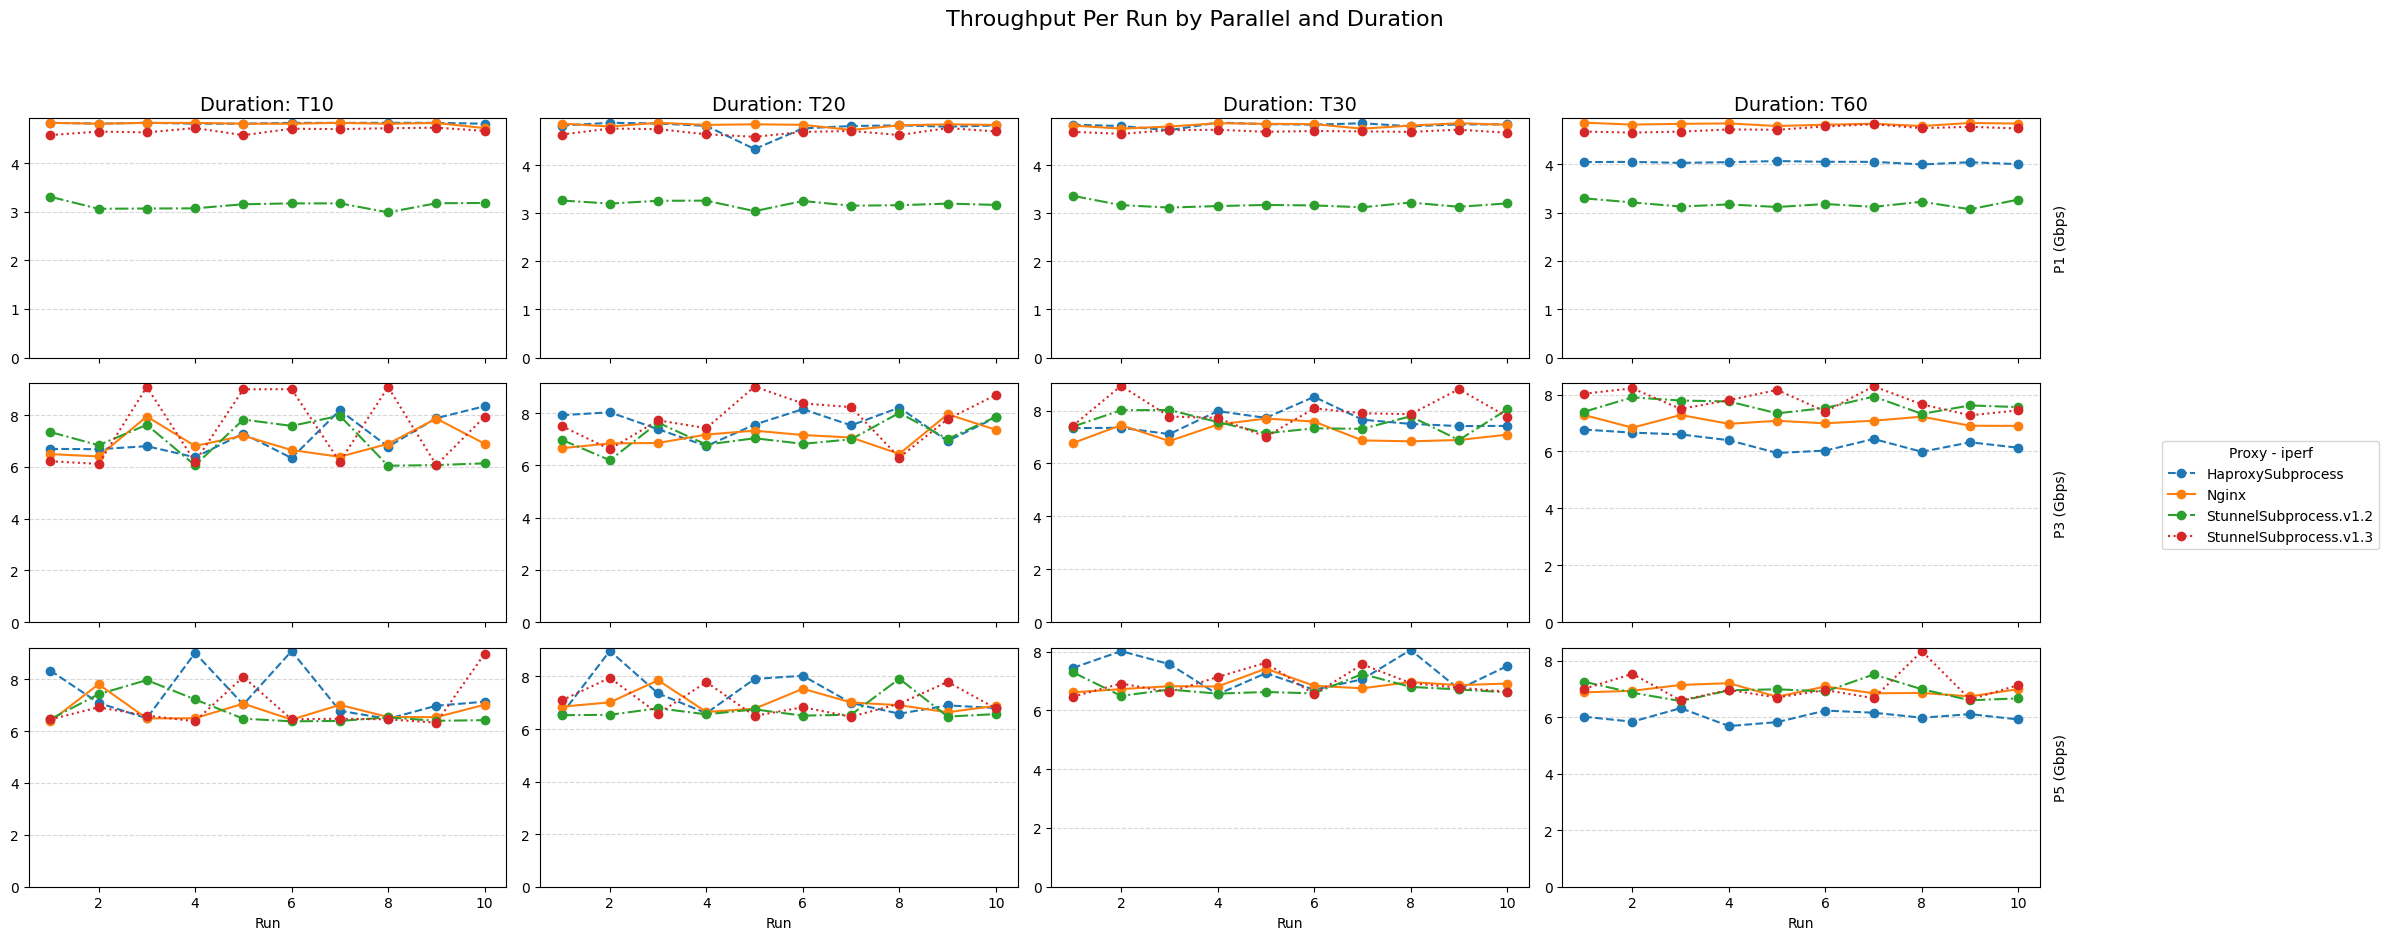

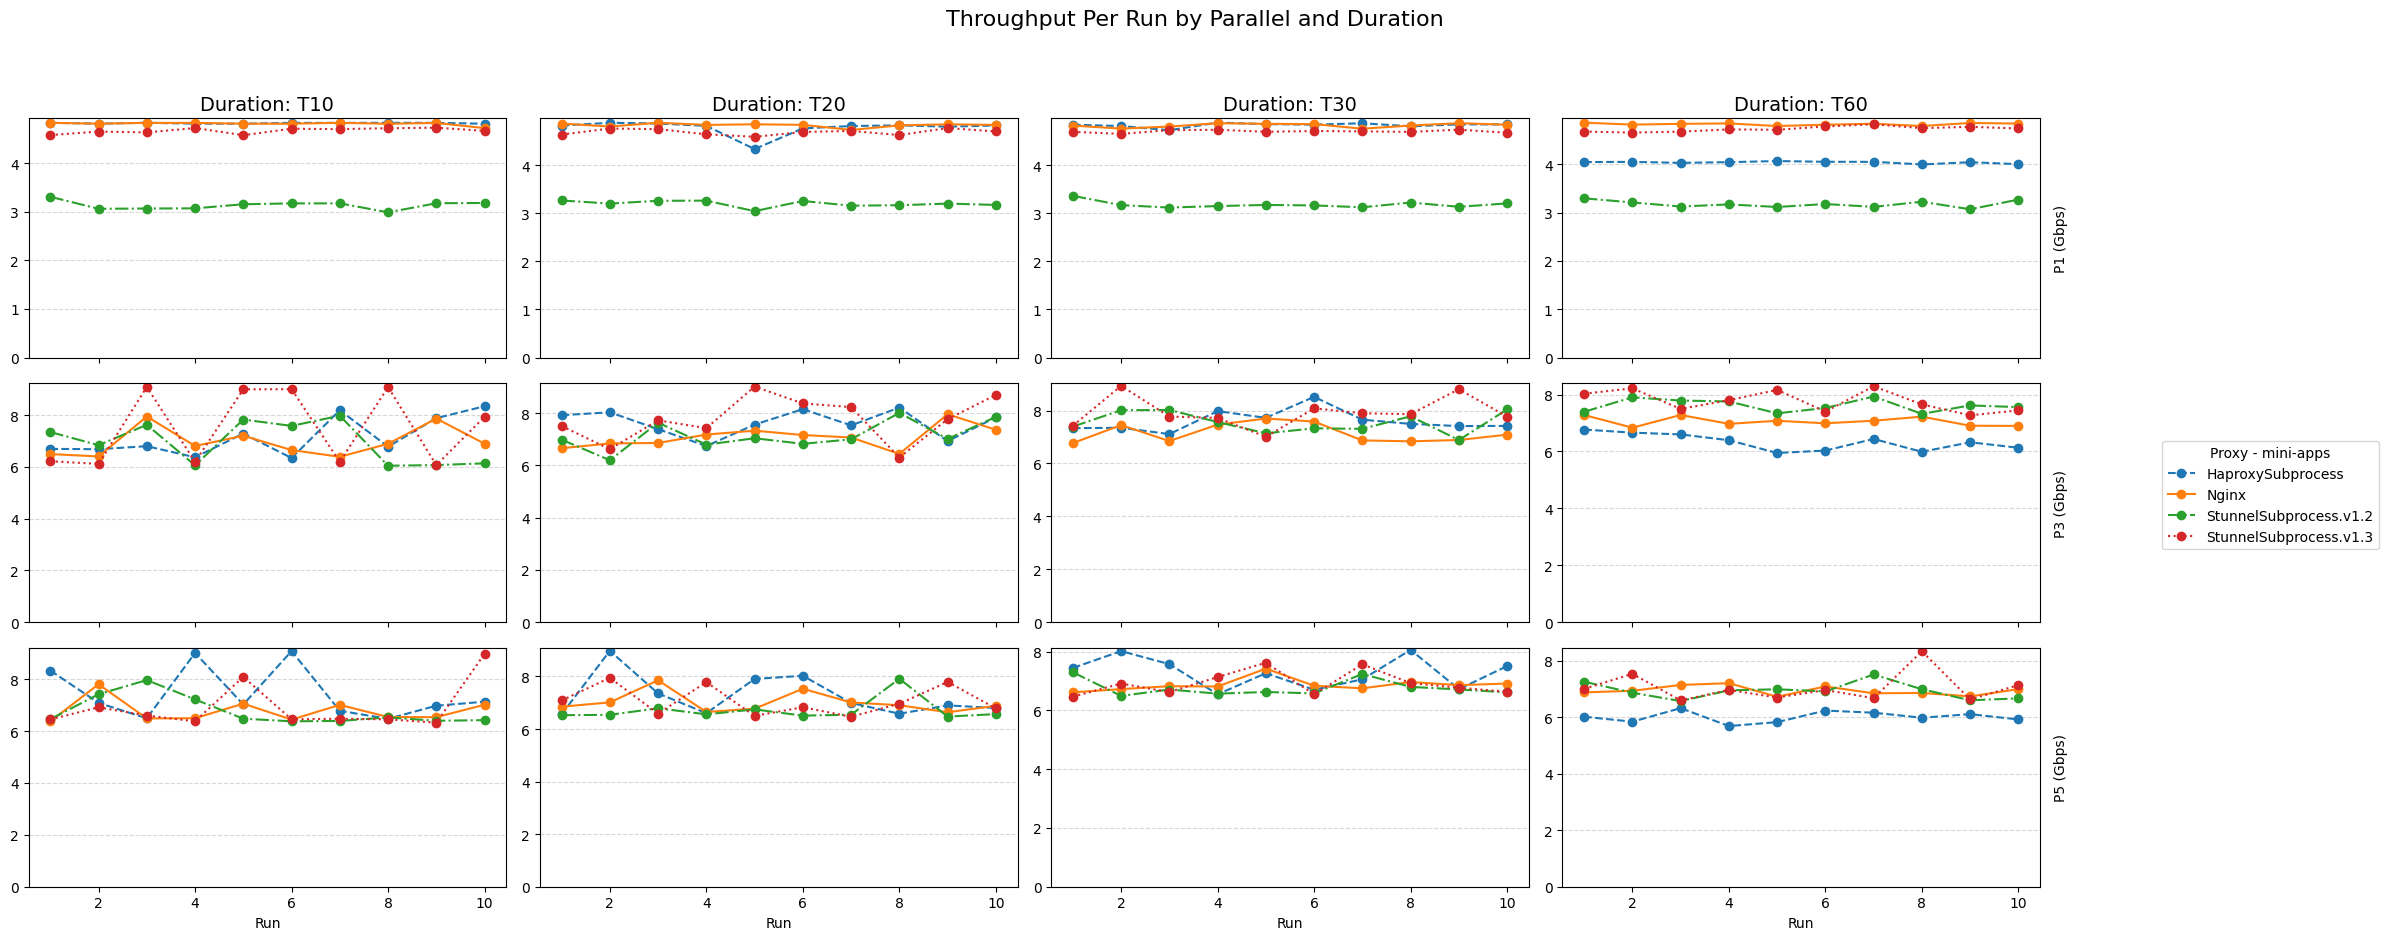

In [7]:
#parallels = ["P1", "P3", "P5"]
#proxies = ["HaproxySubprocess", "Nginx", "StunnelSubprocess.v1.2", "StunnelSubprocess.v1.3"]
#durations = sorted(agg_df["duration"].unique(), key=lambda x: int(x[1:]))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
proxy_linestyles = {
    "Nginx": '-',
    "HaproxySubprocess": '--',
    "StunnelSubprocess.v1.2": '-.',
    "StunnelSubprocess.v1.3": ':'
}

# to plot average of each run for a specific configuration
"""
subset = agg_df[
    (agg_df["app"] == "iperf") &
    (agg_df["proxy"] == "HaproxySubprocess") &
    (agg_df["congestion"] == "bbr") &
    (agg_df["parallel"] == "P1") &
    (agg_df["duration"] == "T10")
].sort_values("run")

# when cols is net_rx_Gbps, use that but if avg_net_rx_Gbps, use that
y_col = "avg_net_rx_Gbps" if "avg_net_rx_Gbps" in subset.columns else "net_rx_Gbps"

plt.figure(figsize=(12, 6))
plt.plot(subset["run"], subset[y_col], marker="o")
plt.xlabel("Run Number")
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Throughput for 10 Runs\n(iperf, HaproxySubprocess, bbr, P1, T10)")
plt.xticks(subset["run"])
plt.grid(True)
plt.tight_layout()
plt.show()
"""
# to plot different times for one configuration
"""
parallels = ["P1", "P3", "P5"]
plt.figure(figsize=(8, 5))

for par in parallels:
    subset = agg_df[
        (agg_df["app"] == "iperf") &
        (agg_df["proxy"] == "HaproxySubprocess") &
        (agg_df["congestion"] == "bbr") &
        (agg_df["parallel"] == par) &
        (agg_df["duration"] == "T10")
    ].sort_values("run")
    plt.plot(subset["run"], subset["avg_net_rx_Gbps"], marker="o", label=f"{par}")

plt.xlabel("Run")
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Per-run Throughput for Different Parallels (T10, bbr, HaproxySubprocess, iperf)")
plt.legend(title="Parallel")
plt.tight_layout()
plt.show()
"""

# 3 plots of per run throughput by proxy and parallel
"""
for par in parallels:
    plt.figure(figsize=(5, 3))
    for proxy in proxies:
        linestyle = proxy_linestyles.get(proxy, '-')
        subset = agg_df[
            (agg_df["app"] == "iperf") &
            (agg_df["proxy"] == proxy) &
            (agg_df["congestion"] == "bbr") &
            (agg_df["parallel"] == par) &
            (agg_df["duration"] == "T10")
        ].sort_values("run")
        if not subset.empty:
            plt.plot(
                subset["run"],
                subset["avg_net_rx_Gbps"],
                linestyle=linestyle,
                marker="*",
                label=f"{proxy}, {par}"
            )

    plt.xlabel("Run")
    plt.ylabel("Avg Net RX Throughput (Gbps)", fontsize='small')
    plt.title("Per-run Throughput by Proxy and Parallel (bbr, T10, iperf)", fontsize='small')
    plt.legend(title="Config/Parallel", fontsize='small')
    plt.tight_layout()
    plt.ylim(bottom=0)
    plt.show()
"""

# 3 subplots in one figure seperating by parallels 
"""
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), sharex=True, gridspec_kw={'hspace': 0.3})
for idx, par in enumerate(parallels):
    ax = axes[idx]
    for i, proxy in enumerate(proxies):
        linestyle = proxy_linestyles.get(proxy, '-')
        subset = agg_df[
            (agg_df["app"] == "iperf") &
            (agg_df["proxy"] == proxy) &
            (agg_df["congestion"] == "bbr") &
            (agg_df["parallel"] == par) &
            (agg_df["duration"] == "T10")
        ].sort_values("run")
        if not subset.empty:
            ax.plot( subset["run"], subset["avg_net_rx_Gbps"], marker="o", linestyle=linestyle, 
                    color=colors[i], label=proxy if idx == 0 else "")
    
    ax.set_ylabel(f"{par} (Gbps)")
    #ax.set_ylim(subset["avg_net_rx_Gbps"].min() - 1, subset["avg_net_rx_Gbps"].max() + 1)
    #ax.set_ylabel(f"{par} (Gbps)", labelpad=30, rotation=0, ha='left', va='center')
    #ax.yaxis.set_label_position("right")
    if idx < len(parallels) - 1:
        ax.tick_params(labelbottom=False)  # show the  x labels only for the last subplot

axes[-1].set_xlabel("Run")
fig.suptitle("Throughput Per Run by Parallel (Discontinuous Y, Shared X)")
axes[0].legend(title="Proxy")  # Show legend only once
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
"""

# 1 plot with 3 subplots in one figure, seperating by parallels
"""
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), sharex=True, gridspec_kw={'hspace': 0.3})
for idx, par in enumerate(parallels):
    ax = axes[idx]
    for i, proxy in enumerate(proxies):
        linestyle = proxy_linestyles.get(proxy, '-')
        subset = agg_df[
            (agg_df["app"] == "iperf") &
            (agg_df["proxy"] == proxy) &
            (agg_df["congestion"] == "bbr") &
            (agg_df["parallel"] == par) &
            (agg_df["duration"] == "T10")
        ].sort_values("run")
        if not subset.empty:
            ax.plot(
                subset["run"], subset["avg_net_rx_Gbps"],
                marker="o", linestyle=linestyle,
                color=colors[i], label=proxy if idx == 0 else ""
            )

    # y-axis label to the right
    ax.set_ylabel(f"{par} (Gbps)", labelpad=35)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5),
    ax.yaxis.set_label_position("right")
    if idx < len(parallels) - 1:
        ax.tick_params(labelbottom=False)

axes[-1].set_xlabel("Run")
fig.suptitle("Throughput Per Run by Parallel (Discontinuous Y, Shared X)", y=1.04)

# break marks // between subplots
d = .03  # size of break mark
for i in range(len(parallels) - 1):
    kwargs = dict(transform=axes[i].transAxes, color='k', clip_on=False)
    axes[i].plot([-d, +d], [-d, +d], **kwargs)                                      # bottom left
    axes[i].plot([1 - d, 1 + d], [-d, +d], **kwargs)                                # bottom right
    kwargs2 = dict(transform=axes[i + 1].transAxes, color='k', clip_on=False)
    axes[i + 1].plot([-d, +d], [1 - d, 1 + d], **kwargs2)                           # top left
    axes[i + 1].plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs2)                     # top right

# legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Proxy", loc='center left', bbox_to_anchor=(1.01, 0.5))

#plt.tight_layout(rect=[0, 0, 0.87, 1])
plt.show()
"""

# all the plots  seperating by parallels and durations showing the relevant fluctuations using //
"""
for dur in durations:
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), sharex=True, gridspec_kw={'hspace': 0.3})

    for idx, par in enumerate(parallels):
        ax = axes[idx]
        for i, proxy in enumerate(proxies):
            linestyle = proxy_linestyles.get(proxy, '-')
            subset = agg_df[
                (agg_df["app"] == "iperf") &
                (agg_df["proxy"] == proxy) &
                (agg_df["congestion"] == "bbr") &
                (agg_df["parallel"] == par) &
                (agg_df["duration"] == dur)
            ].sort_values("run")
            if not subset.empty:
                ax.plot(
                    subset["run"], subset["avg_net_rx_Gbps"],
                    marker="o", linestyle=linestyle,
                    color=colors[i], label=proxy if idx == 0 else ""
                )
        ax.set_ylabel(f"{par} (Gbps)", labelpad=10)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
        ax.yaxis.set_label_position("right")
        if idx < len(parallels) - 1:
            ax.tick_params(labelbottom=False)

    axes[-1].set_xlabel("Run")
    fig.suptitle(f"Throughput Per Run by Parallel (Discontinuous Y, Shared X) | Duration: {dur}", y=.92)

    # break marks // between subplots
    d = .03
    for i in range(len(parallels) - 1):
        kwargs = dict(transform=axes[i].transAxes, color='k', clip_on=False)
        axes[i].plot([-d, +d], [-d, +d], **kwargs)                                      # bottom left
        axes[i].plot([1 - d, 1 + d], [-d, +d], **kwargs)                                # bottom right
        kwargs2 = dict(transform=axes[i + 1].transAxes, color='k', clip_on=False)
        axes[i + 1].plot([-d, +d], [1 - d, 1 + d], **kwargs2)                           # top left
        axes[i + 1].plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs2)                     # top right

    # legend outside the plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Proxy", loc='center left', bbox_to_anchor=(1.01, 0.5))

    #plt.tight_layout(rect=[0, 0, 0.87, 1])
    plt.show()
    """

for app in apps:
    nrows = len(parallels)
    ncols = len(durations)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), sharex=True)
    # if only one duration then axes will be 1D, so make it 2D for easier indexing
    if ncols == 1:
        axes = axes[:, np.newaxis]
    if nrows == 1:
        axes = axes[np.newaxis, :]

    for row_idx, par in enumerate(parallels):
        for col_idx, dur in enumerate(durations):
            ax = axes[row_idx, col_idx]
            for i, proxy in enumerate(proxies):
                linestyle = proxy_linestyles.get(proxy, '-')
                subset = agg_df[
                    (agg_df["app"] == "iperf") &
                    (agg_df["proxy"] == proxy) &
                    (agg_df["congestion"] == "bbr") &
                    (agg_df["parallel"] == par) &
                    (agg_df["duration"] == dur)
                ].sort_values("run")
                if not subset.empty:
                    ax.plot(
                        subset["run"], subset["avg_net_rx_Gbps"],
                        marker="o", linestyle=linestyle,
                        color=colors[i], label=proxy if (row_idx == 0 and col_idx == 0) else ""
                    )
            ax.set_ylim(bottom=0)
            # titles and labels
            if row_idx == 0:
                ax.set_title(f"Duration: {dur}", fontsize=14)
            if col_idx == 3:
                ax.set_ylabel(f"{par} (Gbps)", labelpad=10)
            ax.grid(True, axis='y', linestyle='--', alpha=0.5)
            ax.yaxis.set_label_position("right")
            if row_idx < len(parallels) - 1:
                ax.tick_params(labelbottom=False)
            if row_idx == len(parallels) - 1:
                ax.set_xlabel("Run")

    #legend outside the first subplot
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, title=f"Proxy - {app}", loc='center left', bbox_to_anchor=(.90, 0.5))
    fig.suptitle("Throughput Per Run by Parallel and Duration", y=1.04, fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.87, 1])
    plt.show()




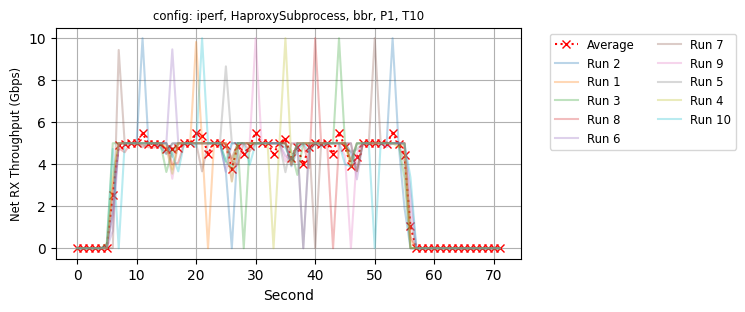

In [8]:
if "second" not in df.columns:
    df["second"] = df.groupby(['app', 'proxy', 'congestion', 'parallel', 'duration', 'run']).cumcount()


# all parallels in one config
"""for par in ["P1", "P3", "P5"]:
    sub = df[
        (df["app"] == "iperf") &
        (df["proxy"] == "HaproxySubprocess") &
        (df["congestion"] == "bbr") &
        (df["parallel"] == par) &
        (df["duration"] == "T10")
    ]
    avg_by_sec = sub.groupby("second")["net_rx_Gbps"].mean().reset_index()
    plt.plot(avg_by_sec["second"], avg_by_sec["net_rx_Gbps"], marker='o', label=par)

plt.xlabel("Second")
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Avg Throughput per Second (by Parallel)")
plt.grid(True)
plt.legend(title="Parallel")
plt.show()"""


# config iperf, HaproxySubprocess, bbr, P1, T10
subset = df[
    (df["app"] == "iperf") &
    (df["proxy"] == "HaproxySubprocess") &
    (df["congestion"] == "bbr") &
    (df["parallel"] == "P1") &
    (df["duration"] == "T60")
]

# average throughput at each second across all runs
avg_by_sec = (
    subset.groupby("second")["net_rx_Gbps"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 3))
plt.plot(avg_by_sec["second"], avg_by_sec["net_rx_Gbps"], marker='x', linestyle=':', color='red', label='Average')
for run in subset["run"].unique():
    df_run = subset[subset["run"] == run]
    plt.plot(df_run["second"], df_run["net_rx_Gbps"], alpha=0.3, label=f"Run {run}")
plt.xlabel("Second")
plt.ylabel("Net RX Throughput (Gbps)", fontsize='small')
plt.title("config: iperf, HaproxySubprocess, bbr, P1, T10", fontsize='small')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncols=2)  # put legend outside
#plt.tight_layout()
plt.show()



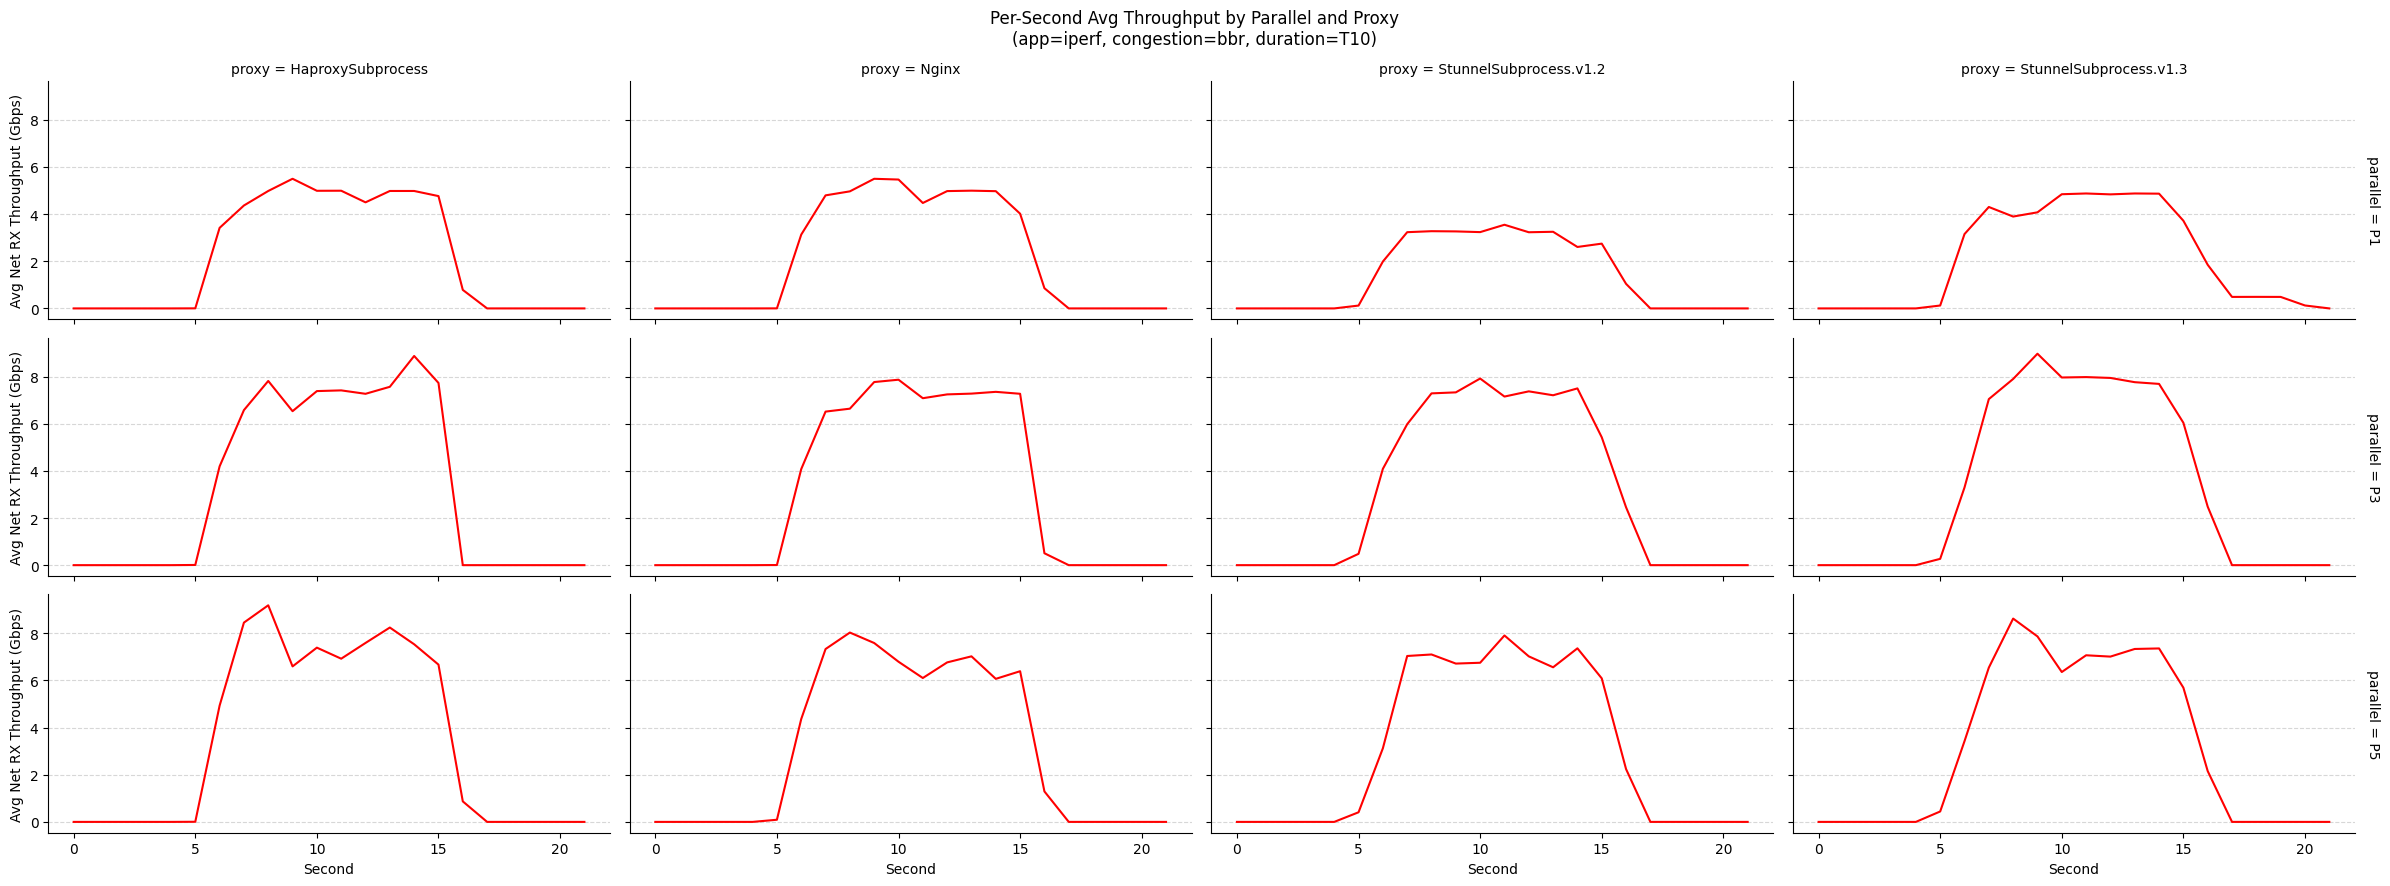

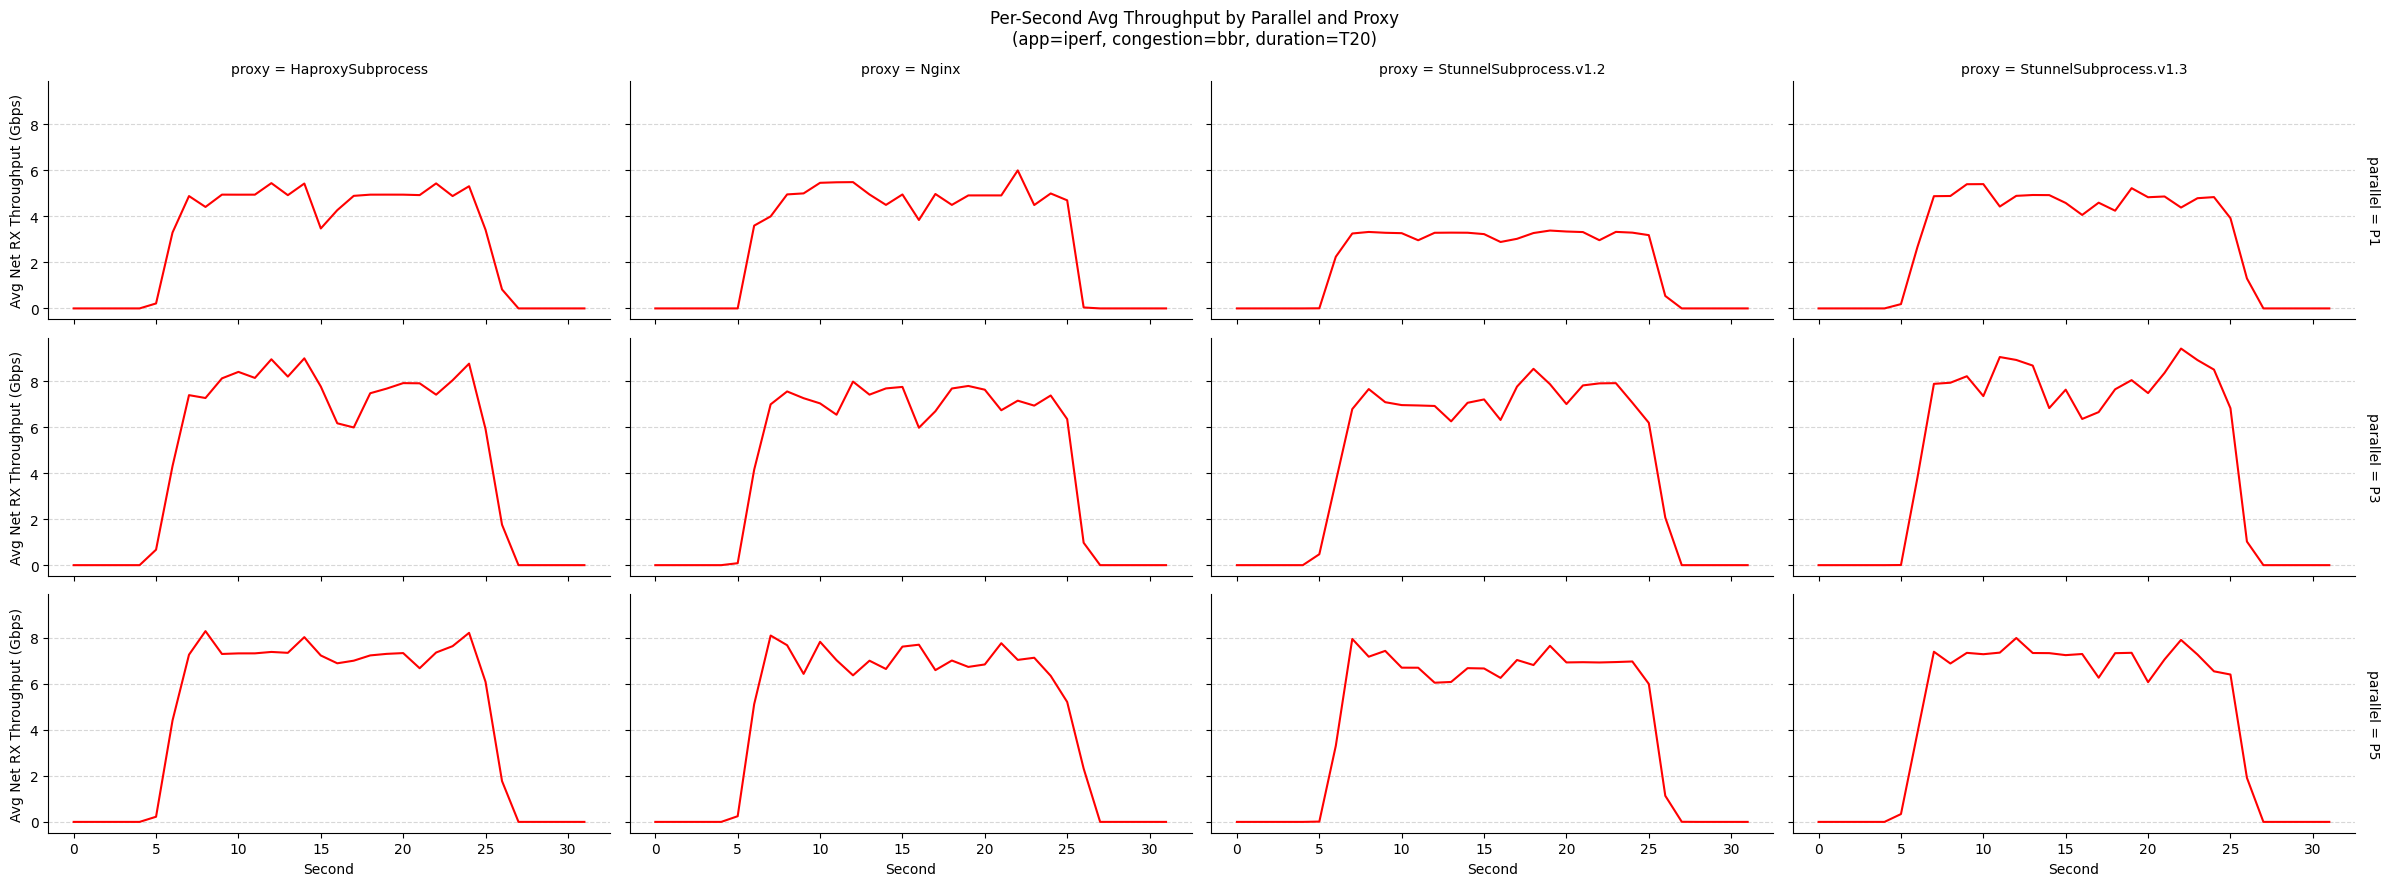

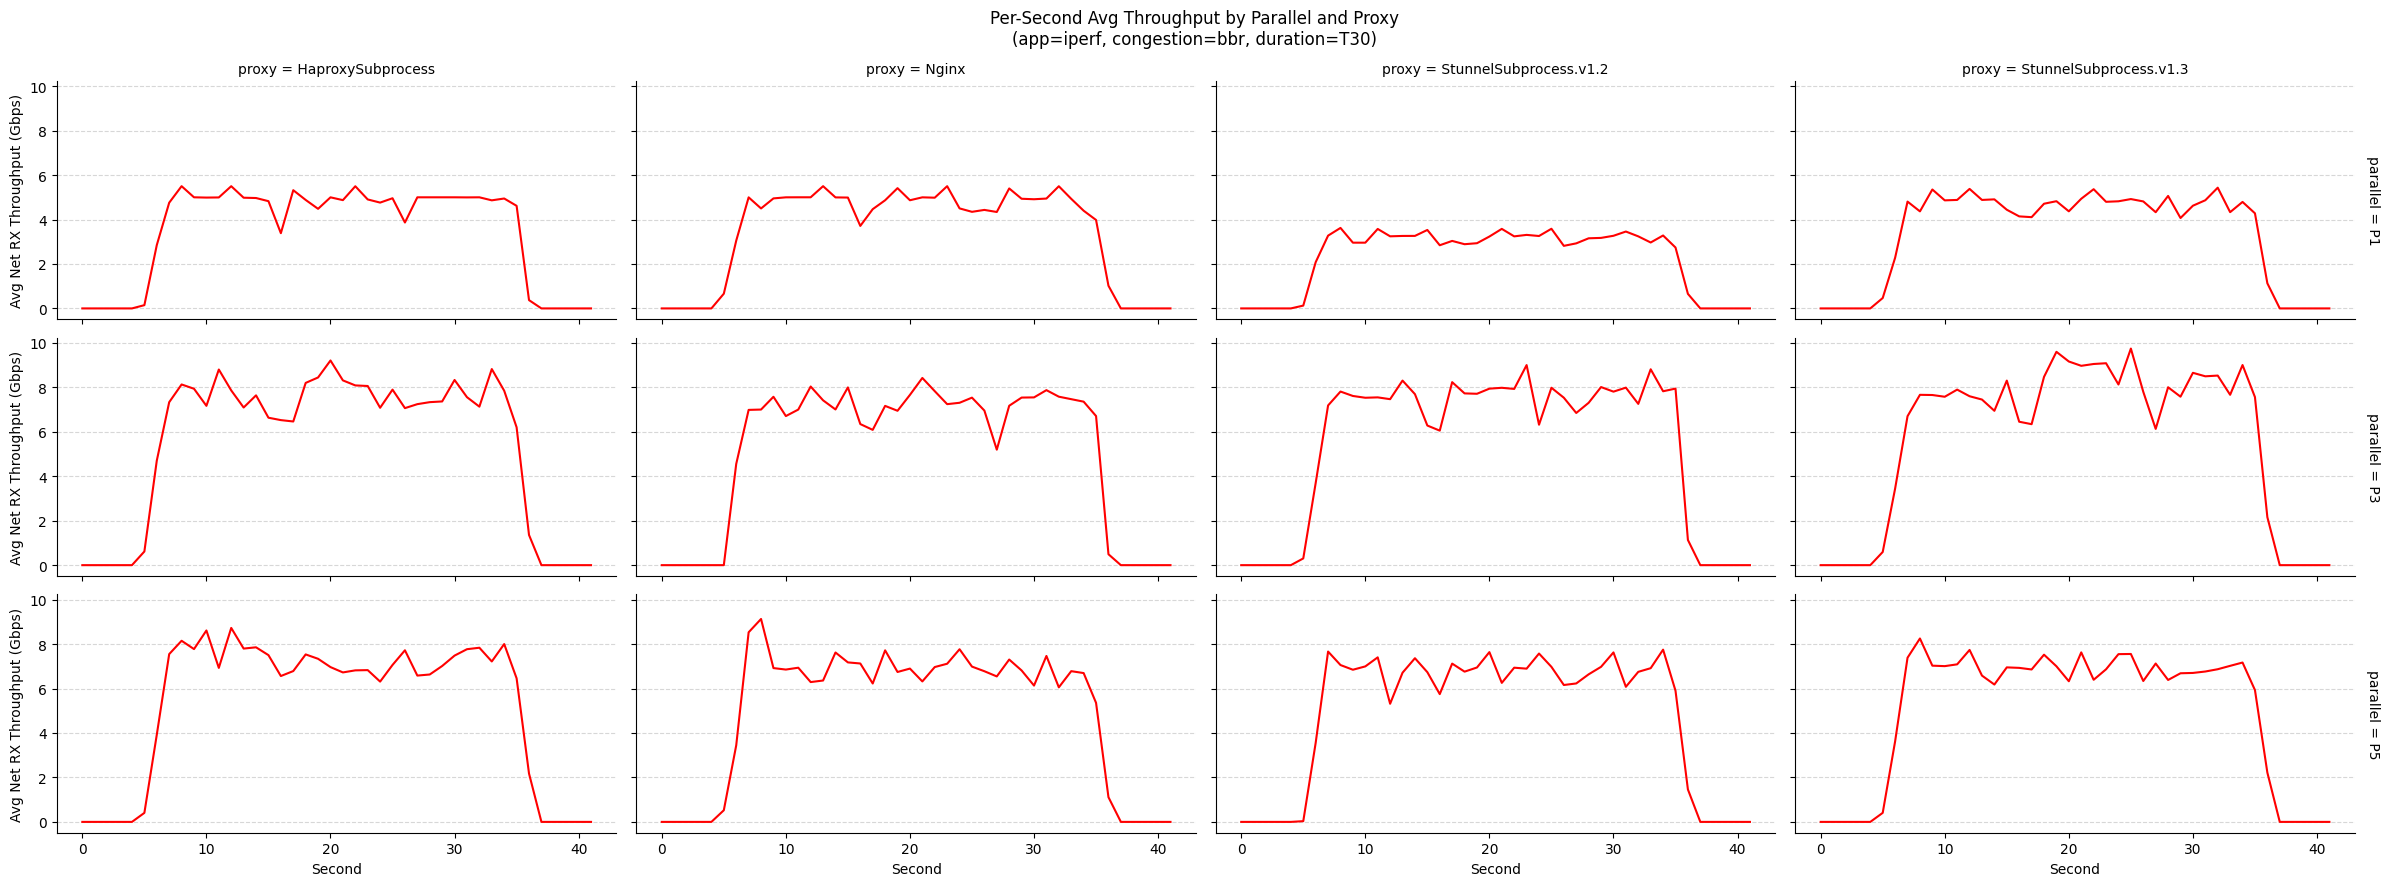

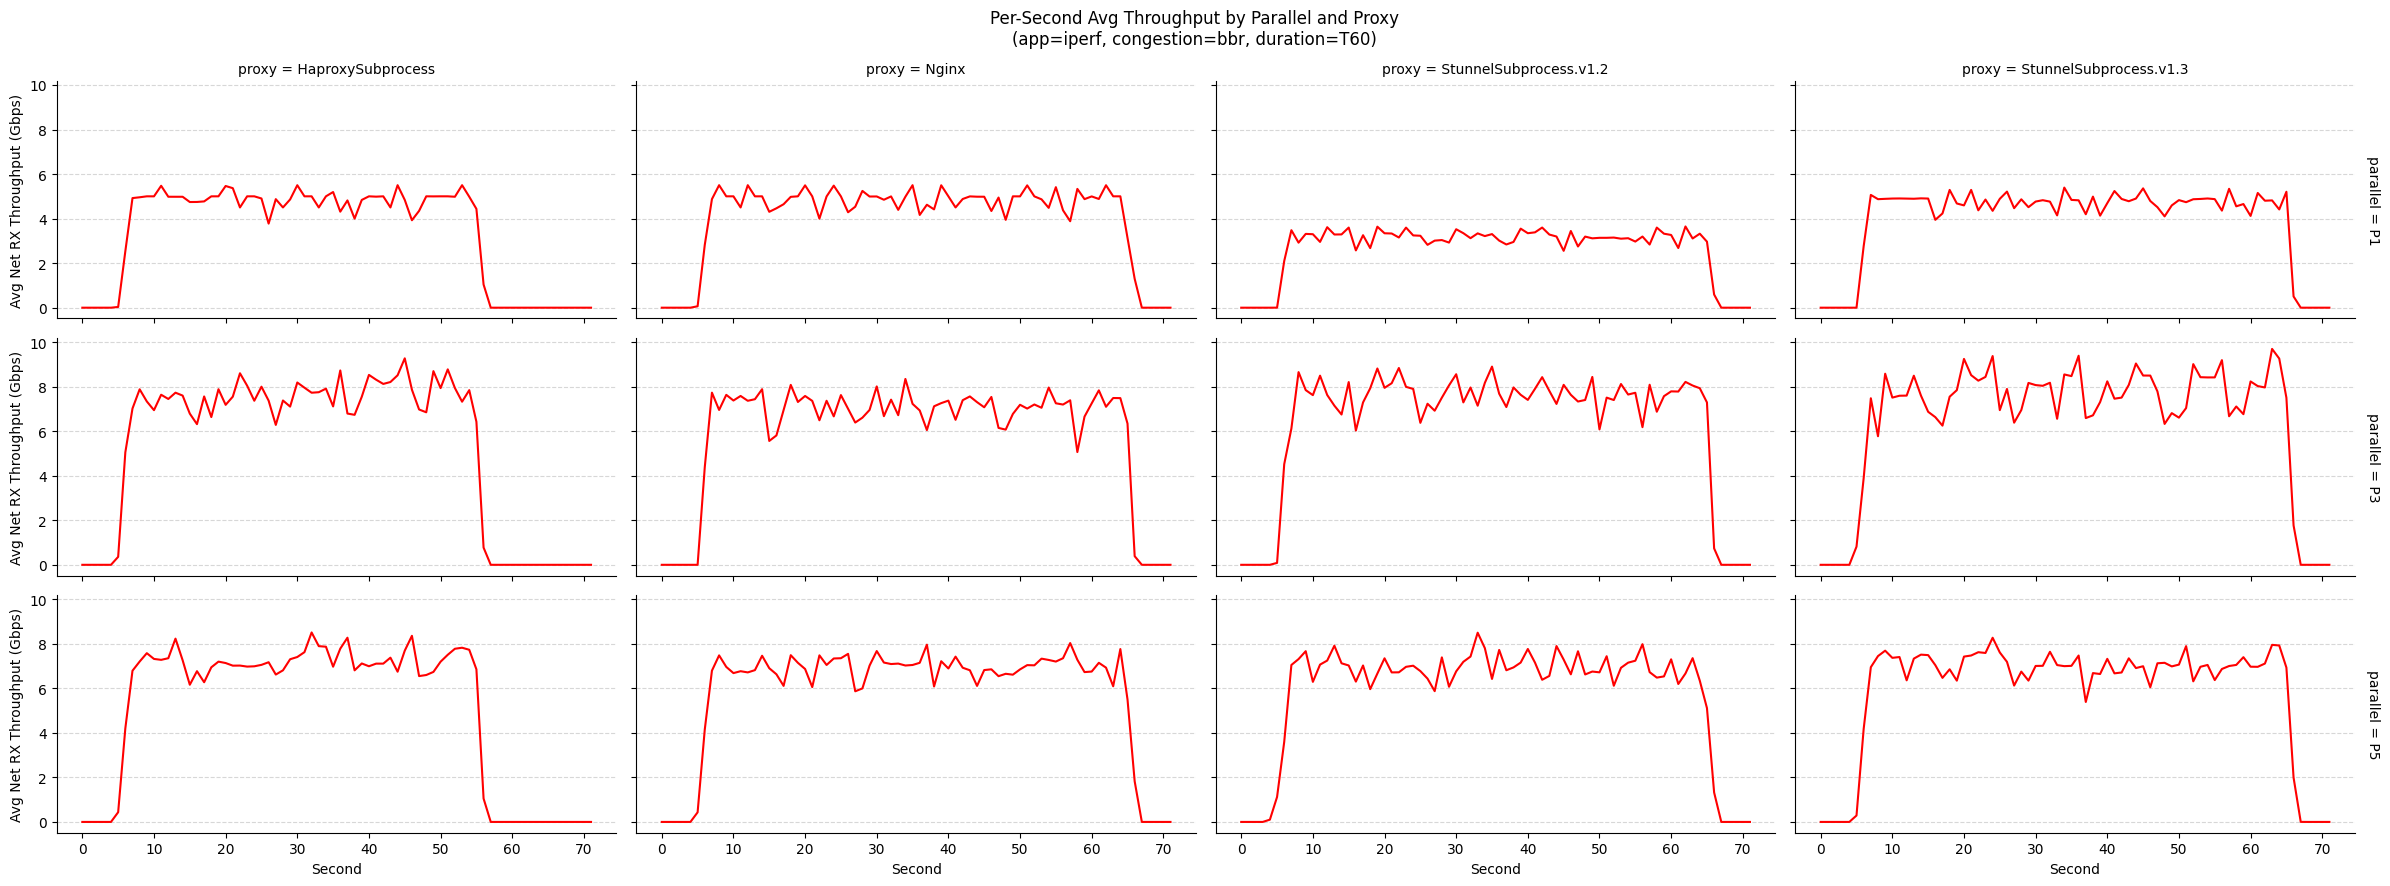

In [9]:

if "second" not in df.columns:
    df["second"] = df.groupby(['app', 'proxy', 'congestion', 'parallel', 'duration', 'run']).cumcount()
durations = sorted(df["duration"].unique(), key=lambda x: int(x[1:])) 

for dur in durations:
    # filter for one app, congestion, duration
    facet_df = df[
        (df["app"] == "iperf") &
        (df["congestion"] == "bbr") &
        (df["duration"] == dur)
    ].copy()

    # mean throughput per config per second
    facet_df_avg = (
        facet_df
        .groupby(['proxy', 'parallel', 'second'], as_index=False)["net_rx_Gbps"]
        .mean()
    )

    # rows = parallel, cols = proxy
    g = sns.FacetGrid(
        facet_df_avg, row="parallel", col="proxy", 
        margin_titles=True, height=3, aspect=2
    )
    for ax in g.axes.flat:
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    g.map_dataframe(sns.lineplot, x="second", y="net_rx_Gbps", color='red')
    g.set_axis_labels("Second", "Avg Net RX Throughput (Gbps)")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Per-Second Avg Throughput by Parallel and Proxy\n(app=iperf, congestion=bbr, duration={dur})")
    plt.show()


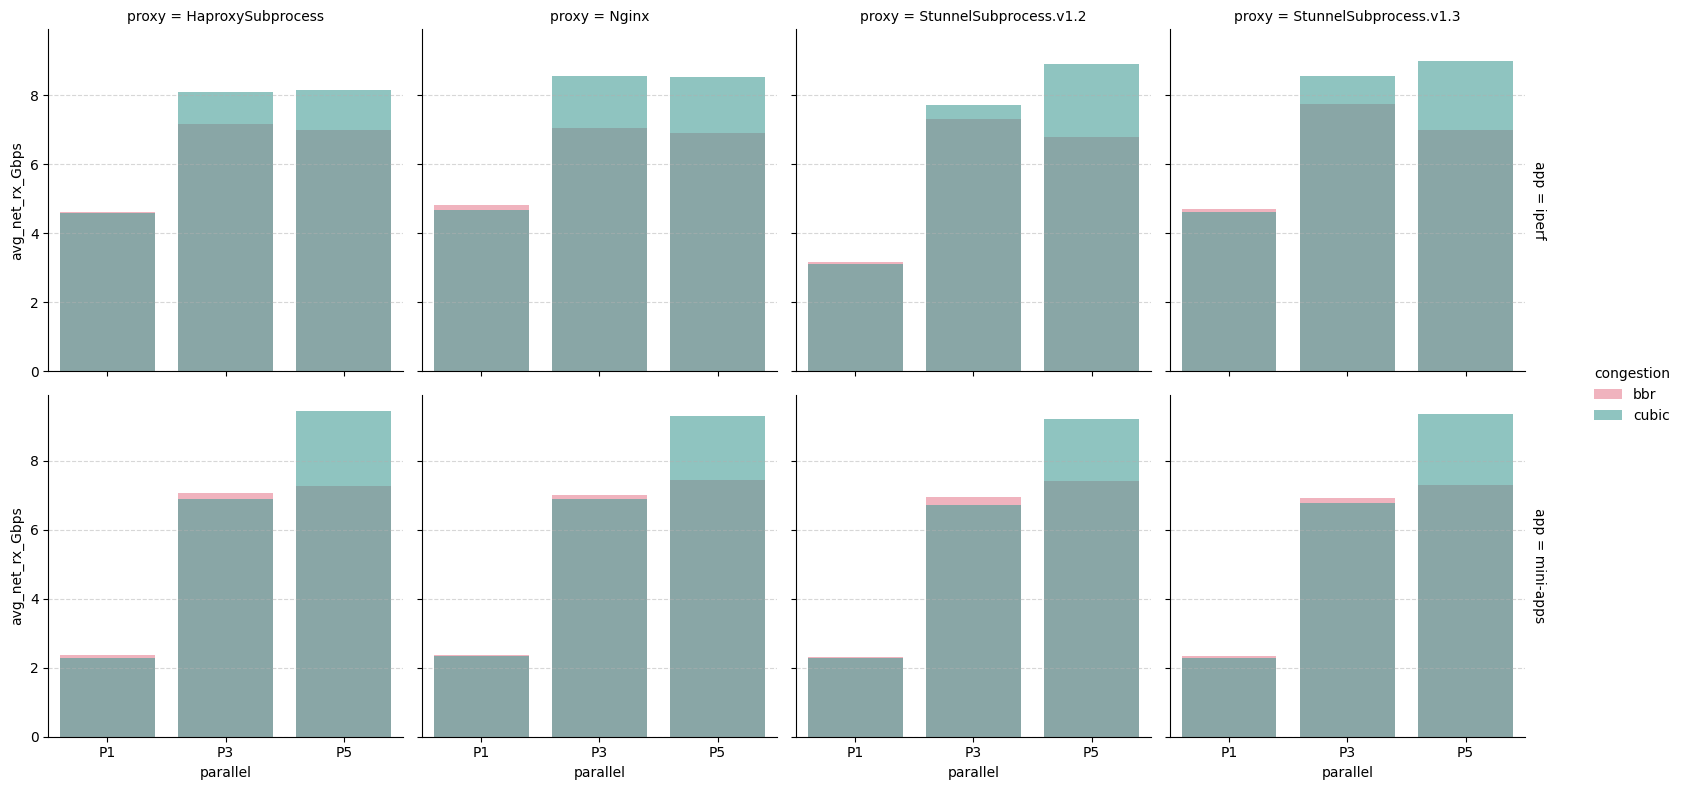

In [10]:
#sets:  deep, muted, bright, pastel, dark, colorblind, husl, Set1, Set2, Set3, sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

g = sns.FacetGrid(
    agg_config_df, row="app", col="proxy", hue="congestion", 
    margin_titles=True, height=4, palette="husl"
)
for ax in g.axes.flat:
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
g.map(sns.barplot, "parallel", "avg_net_rx_Gbps", order=sorted(agg_config_df["parallel"].unique()), alpha=0.6, errorbar=None)
g.add_legend()
plt.show()


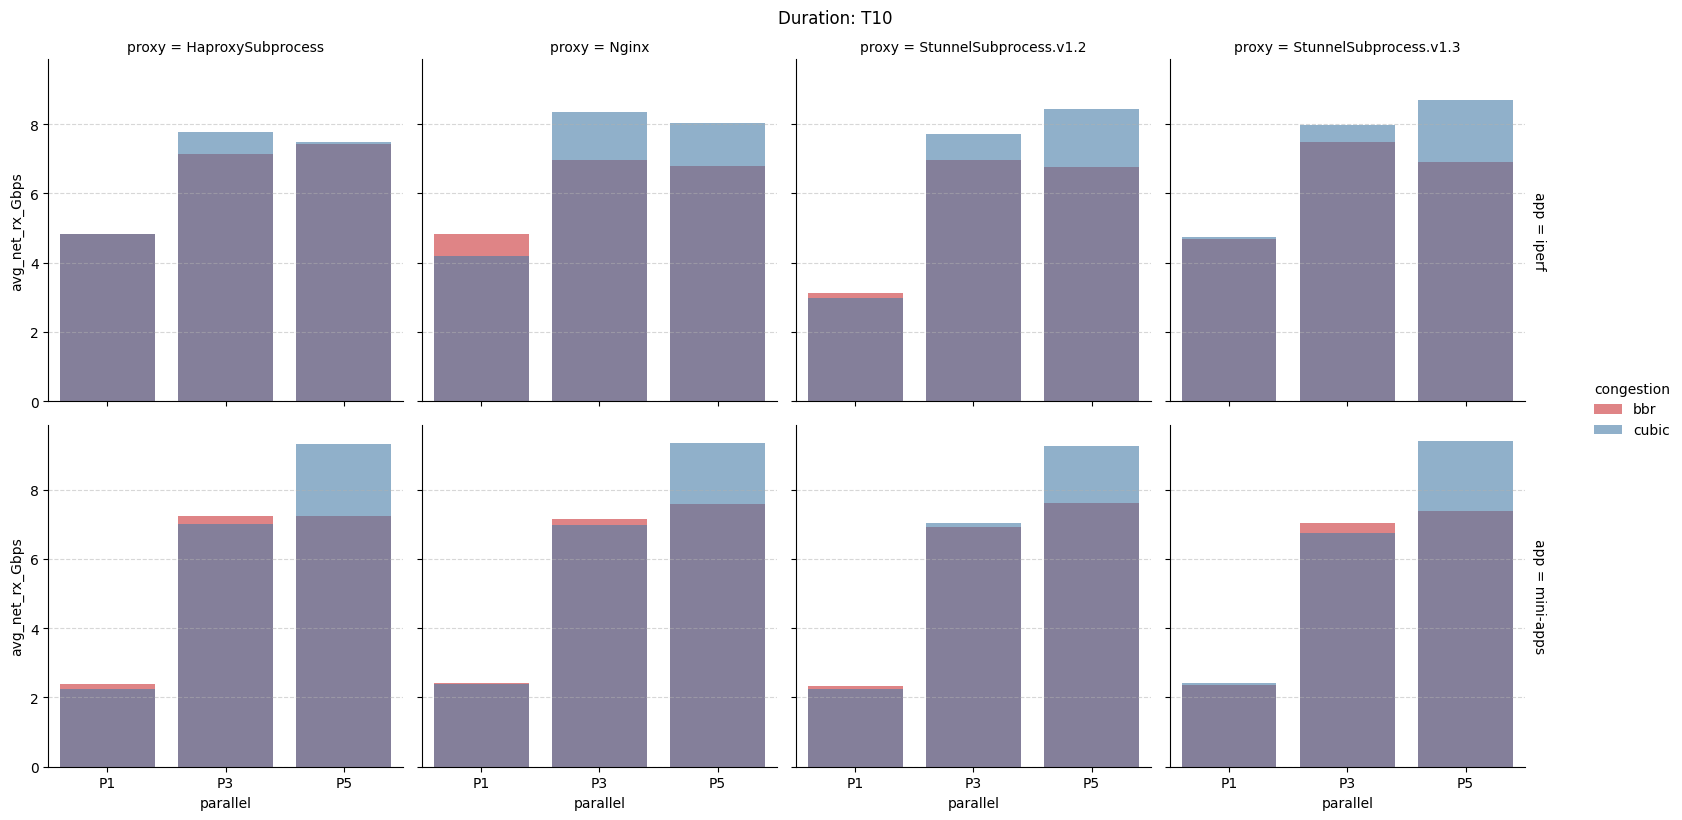

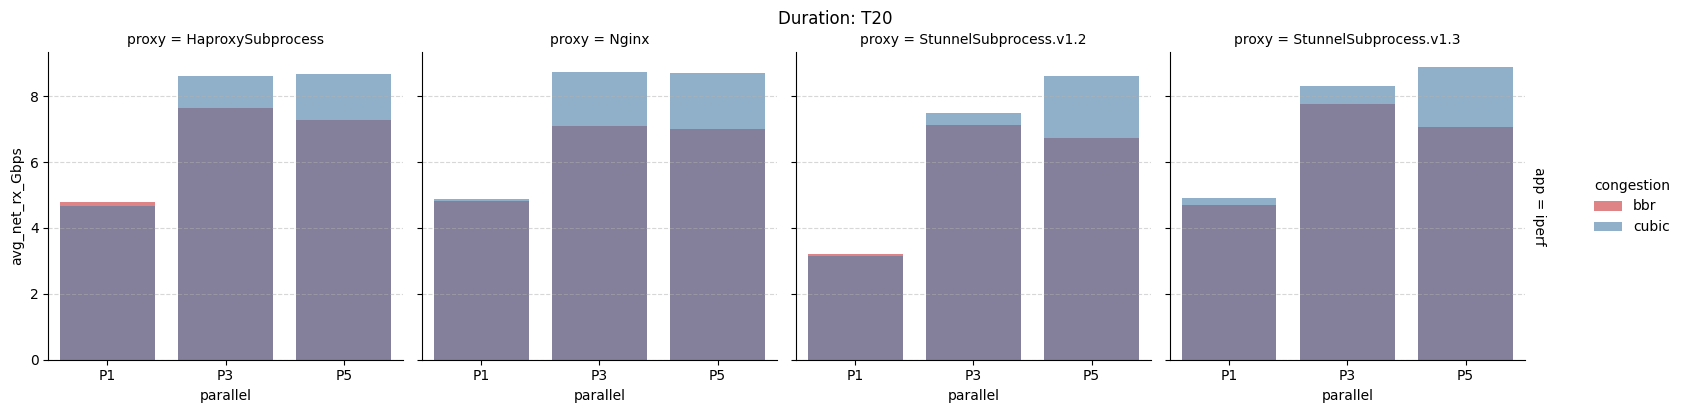

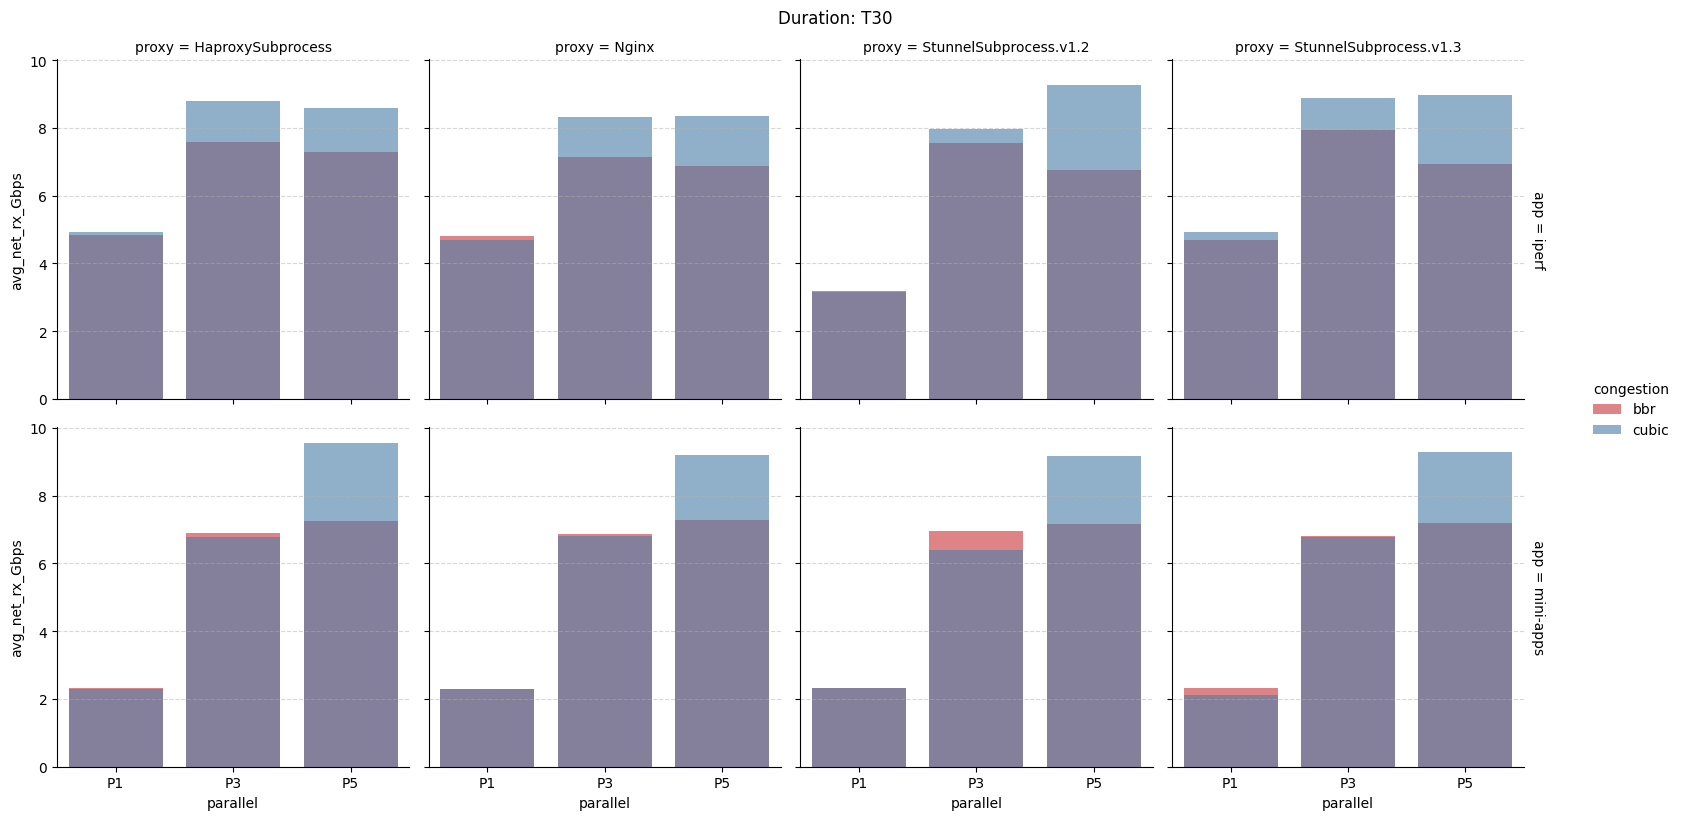

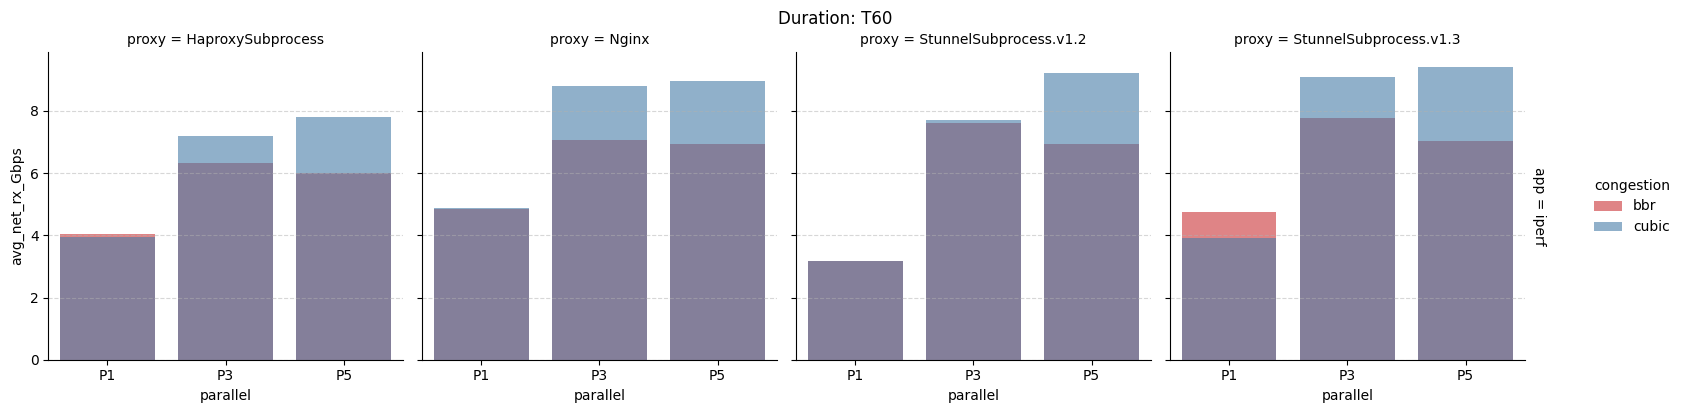

In [16]:
durations = sorted(agg_config_df["duration"].unique(), key=lambda x: int(x[1:]))
for dur in durations:
    subset = agg_config_df[agg_config_df["duration"] == dur]
    g = sns.FacetGrid(
        subset, 
        row="app", col="proxy", hue="congestion",
        margin_titles=True, height=4, palette="Set1"
    )
    for ax in g.axes.flat:
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    g.map(sns.barplot, "parallel", "avg_net_rx_Gbps", order=sorted(subset["parallel"].unique()), alpha=0.6)
    g.add_legend()
    plt.suptitle(f"Duration: {dur}", y=1.02)
    plt.show()

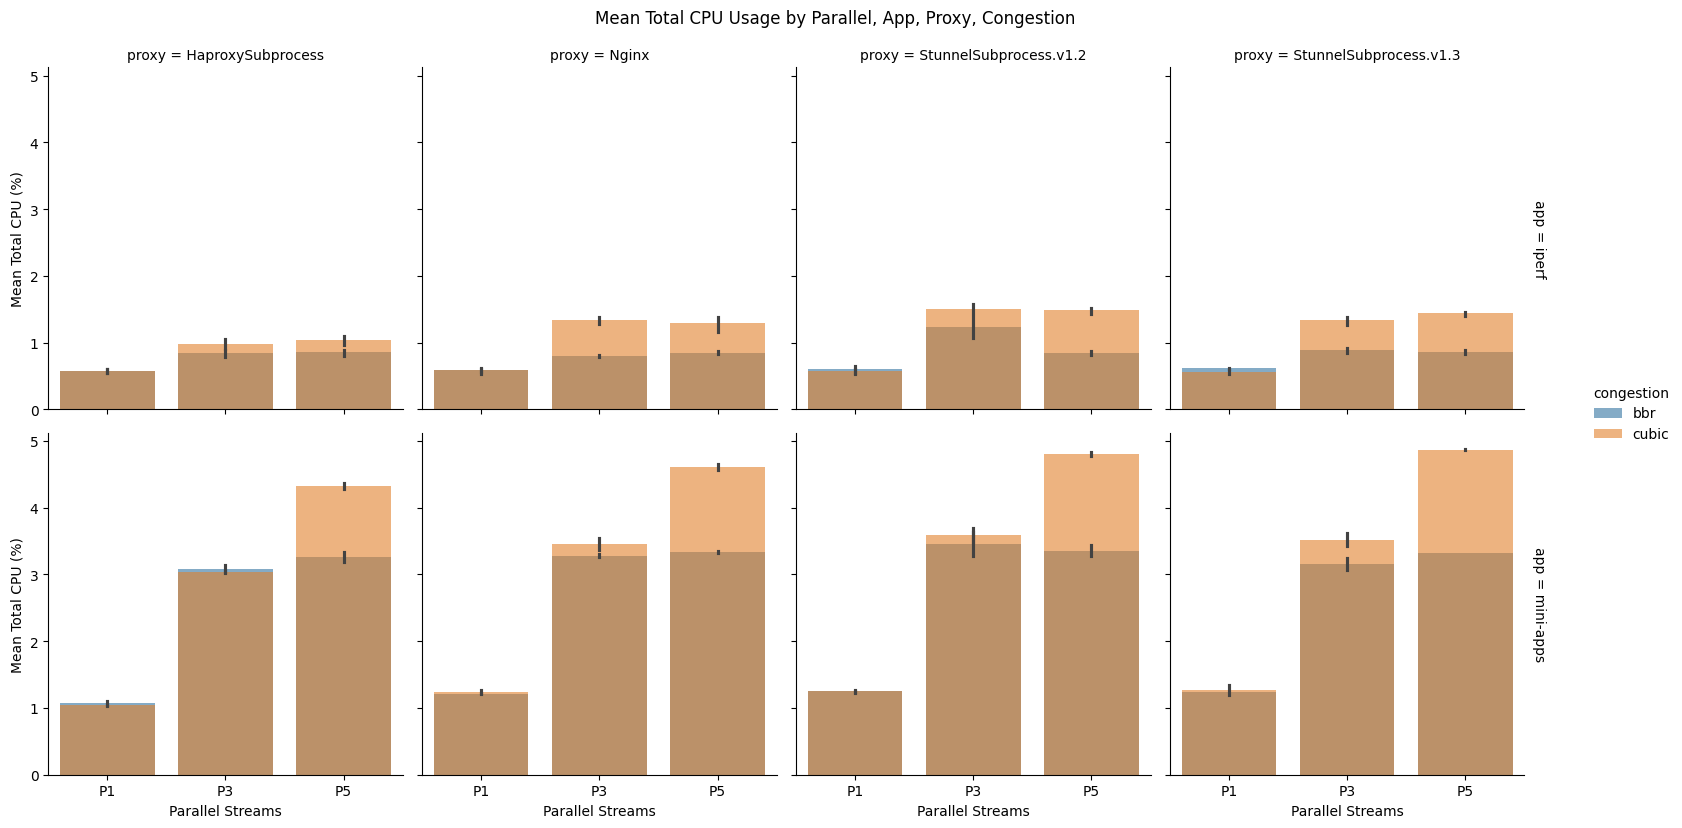

In [17]:
g = sns.FacetGrid(
    agg_config_df, 
    row="app", col="proxy", hue="congestion", 
    margin_titles=True, height=4
)
g.map(
    sns.barplot,
    "parallel", "mean_total_cpu",
    order=sorted(agg_config_df["parallel"].unique()),
    alpha=0.6
)
g.add_legend()
g.set_axis_labels("Parallel Streams", "Mean Total CPU (%)")
g.fig.suptitle("Mean Total CPU Usage by Parallel, App, Proxy, Congestion", y=1.03)
plt.show()

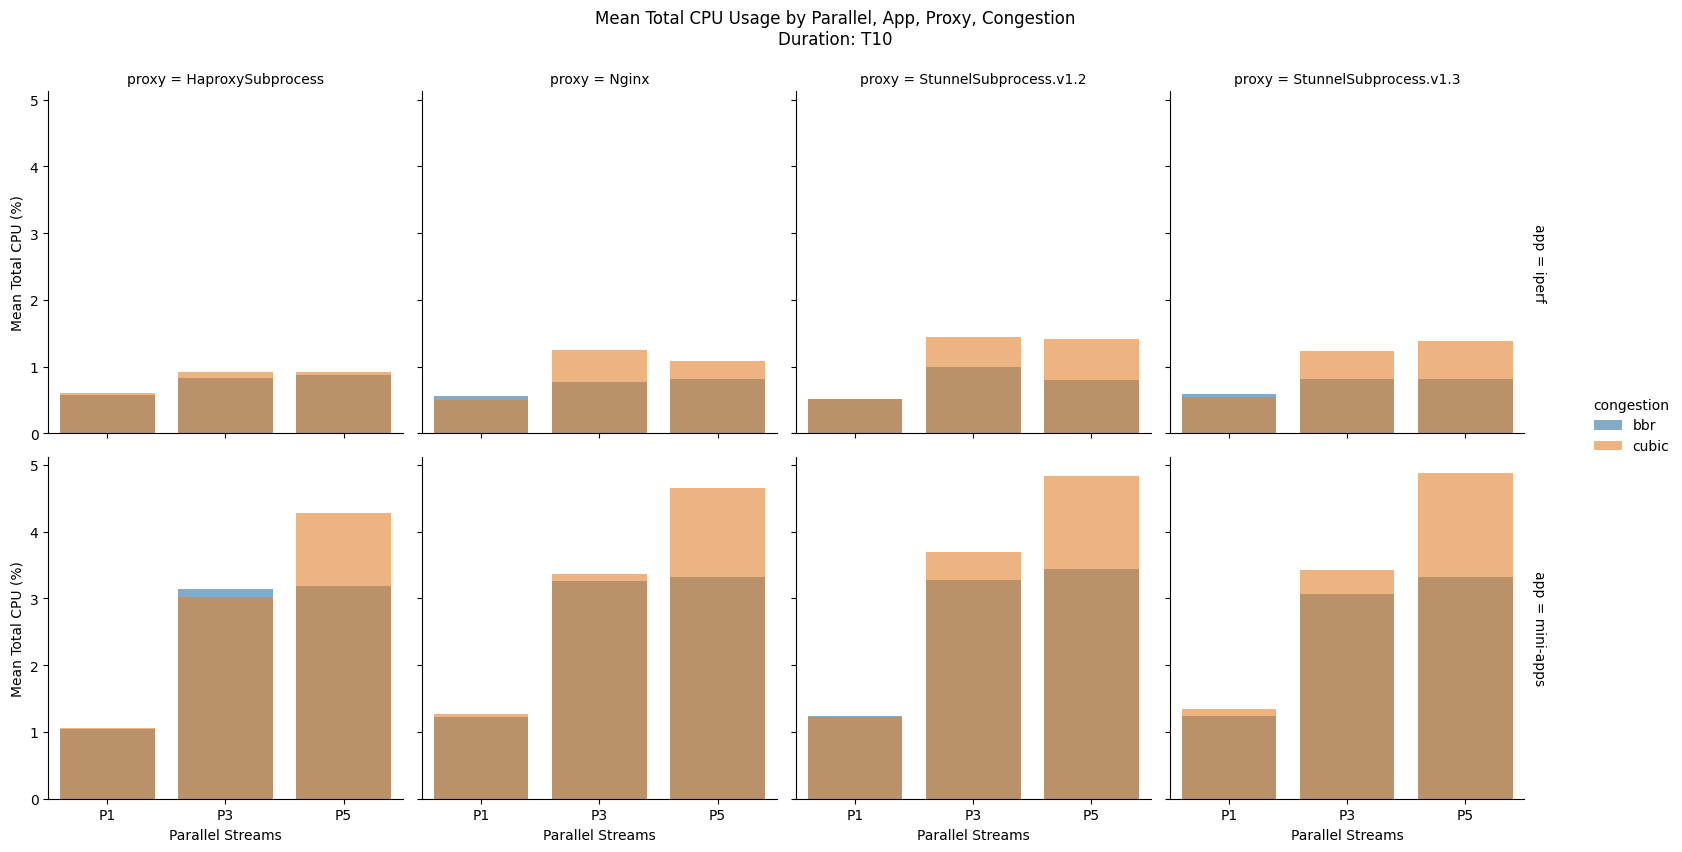

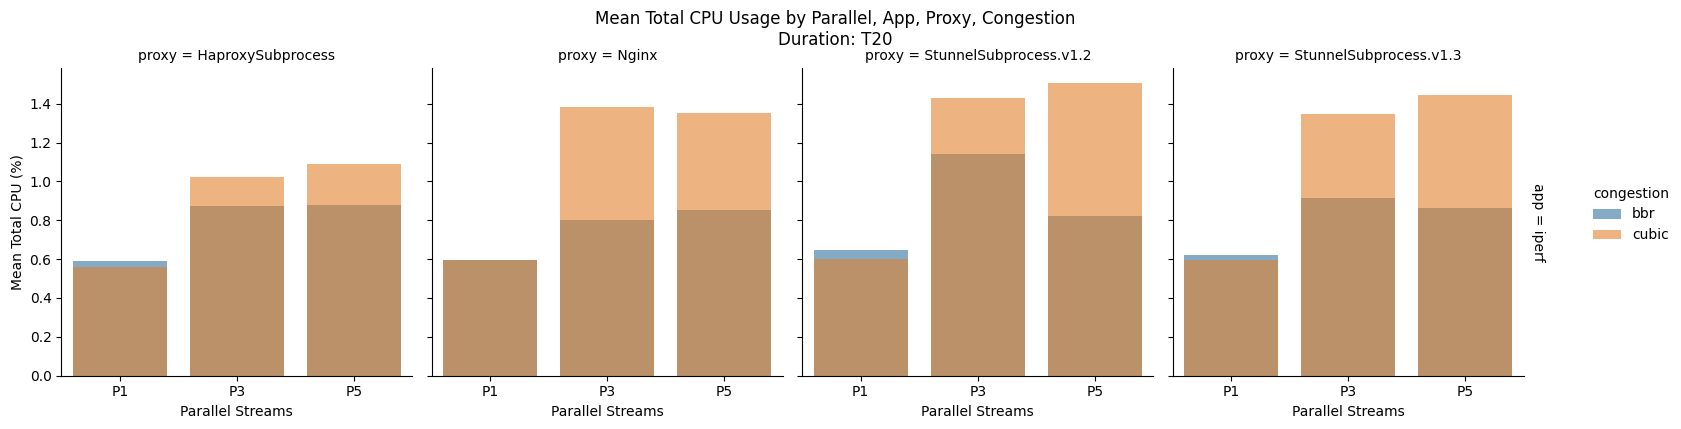

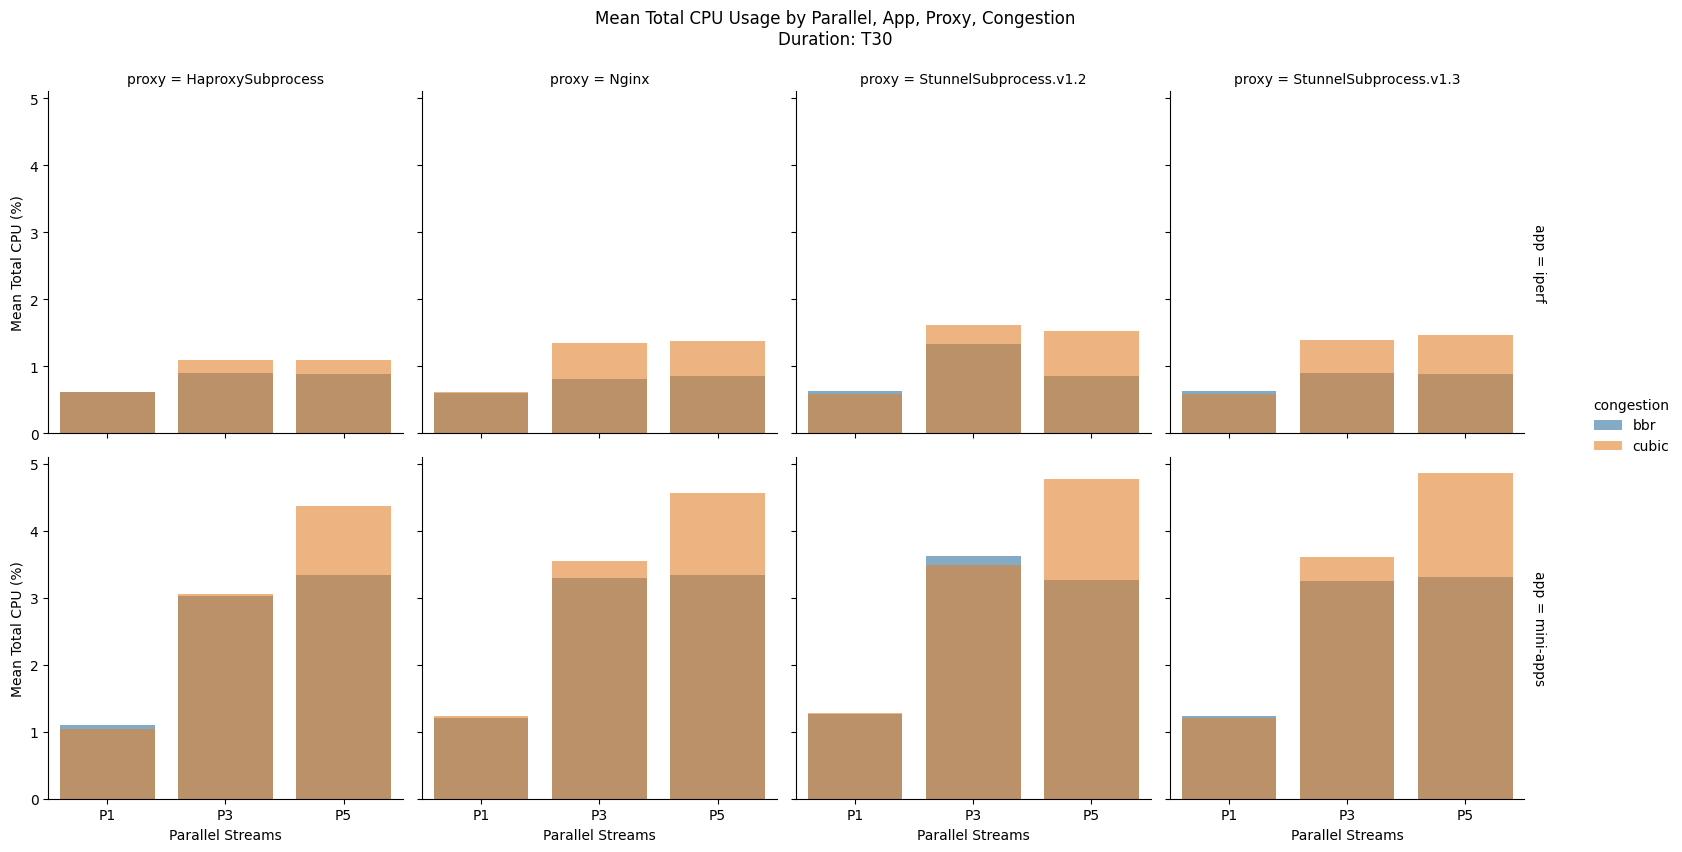

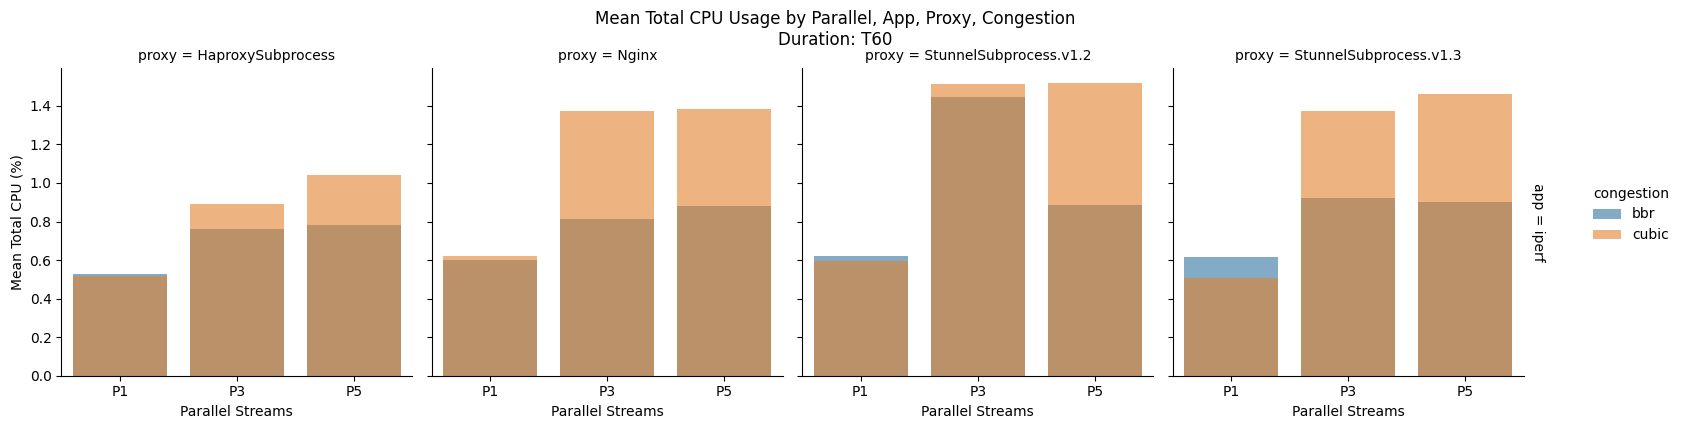

In [26]:
durations = sorted(agg_config_df["duration"].unique(), key=lambda x: int(x[1:]))

for dur in durations:
    subset = agg_config_df[agg_config_df["duration"] == dur]
    g = sns.FacetGrid(subset, row="app", col="proxy", hue="congestion", margin_titles=True, height=4, aspect=1)
    g.map(sns.barplot, "parallel", "mean_total_cpu", order=sorted(subset["parallel"].unique()), alpha=0.6)
    
    g.add_legend()
    g.set_axis_labels("Parallel Streams", "Mean Total CPU (%)")
    g.fig.suptitle(f"Mean Total CPU Usage by Parallel, App, Proxy, Congestion\nDuration: {dur}", y=1.06)
    #plt.tight_layout()
    plt.show()


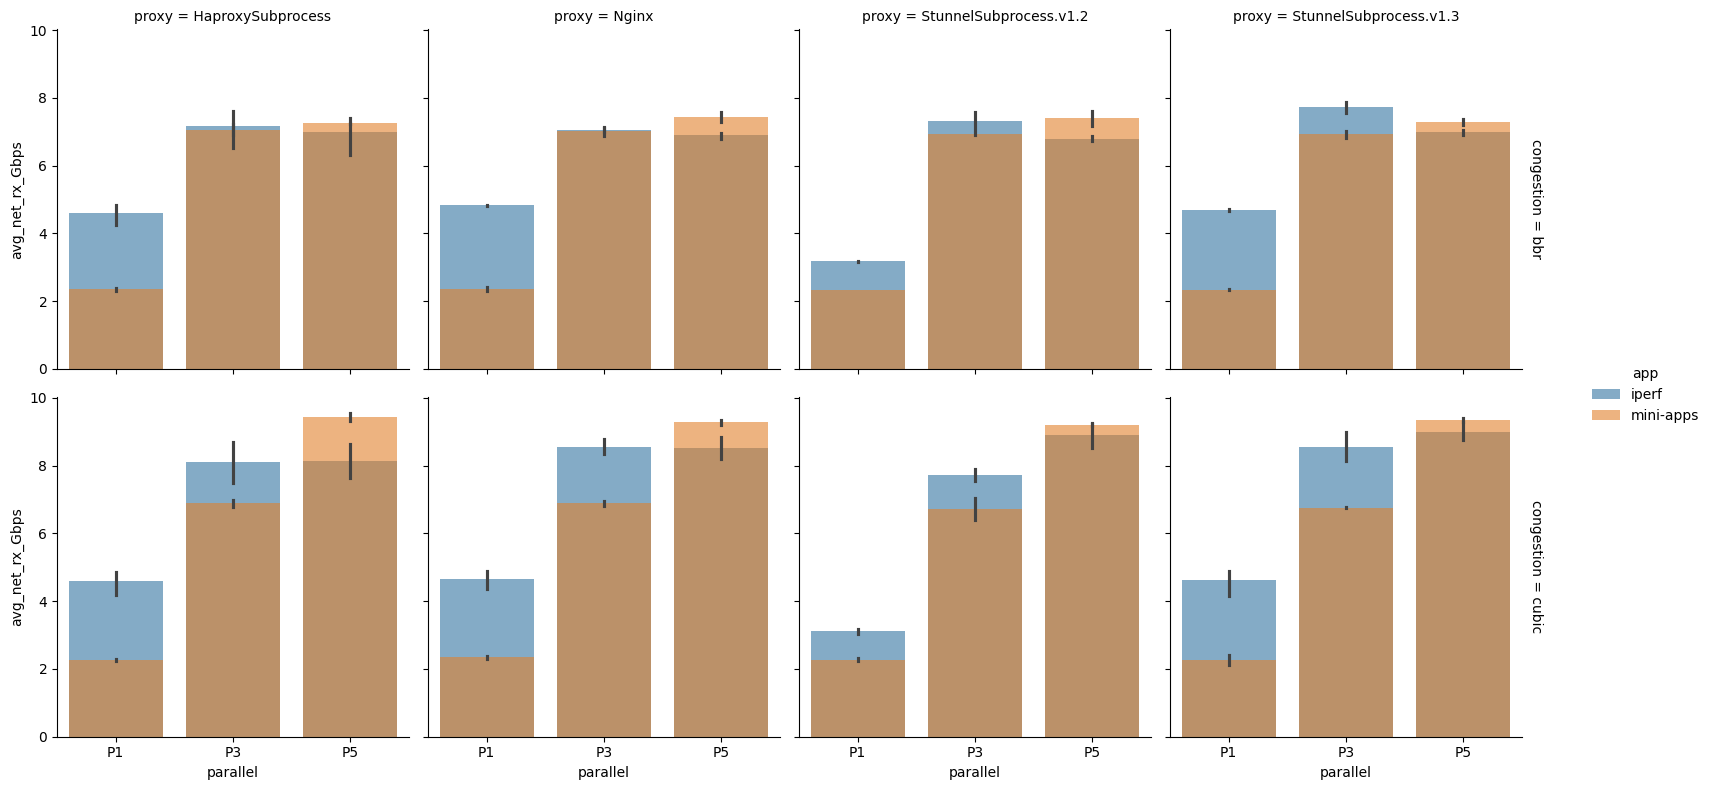

In [28]:
g = sns.FacetGrid(
    agg_config_df,
    row="congestion", col="proxy", hue="app",
    margin_titles=True, height=4
)
g.map(sns.barplot, "parallel", "avg_net_rx_Gbps", order=sorted(agg_config_df["parallel"].unique()), alpha=0.6)
g.add_legend()
plt.show()


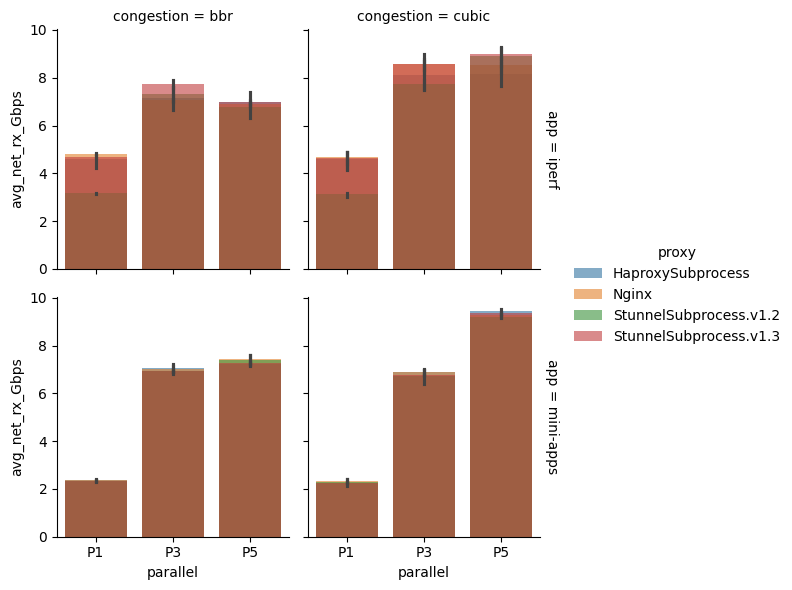

In [29]:
g = sns.FacetGrid(
    agg_config_df,
    row="app", col="congestion", hue="proxy",
    margin_titles=True, height=3
)
g.map(sns.barplot, "parallel", "avg_net_rx_Gbps", order=sorted(agg_config_df["parallel"].unique()), alpha=0.6)
g.add_legend()
plt.show()


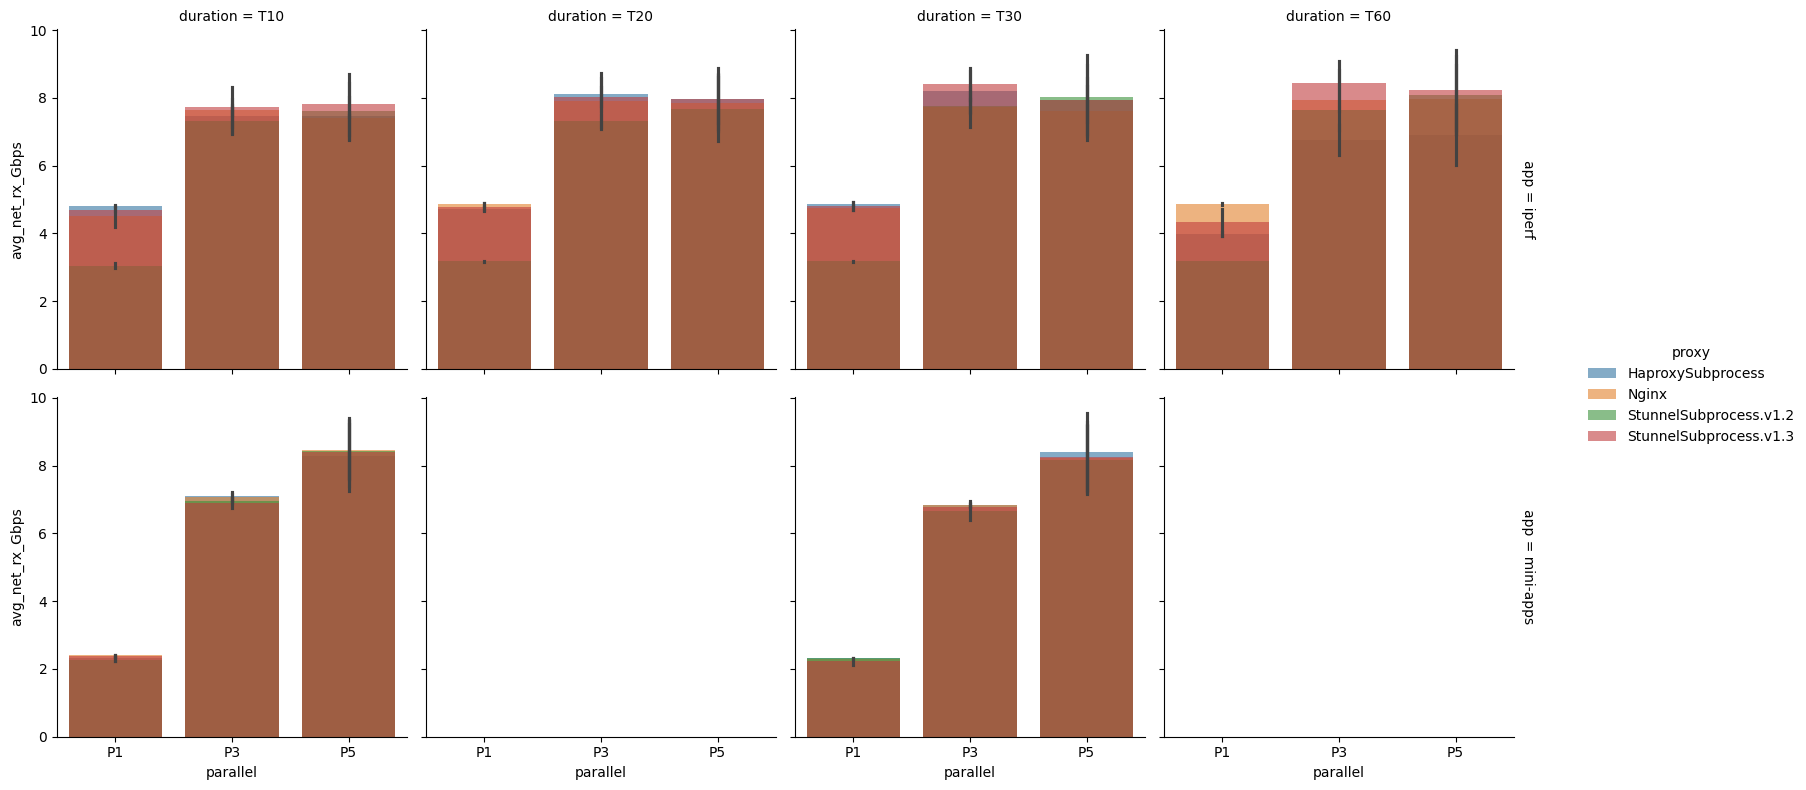

In [30]:
# 
g = sns.FacetGrid(
    agg_config_df,
    row="app", col="duration", hue="proxy",
    margin_titles=True, height=4
)
g.map(sns.barplot, "parallel", "avg_net_rx_Gbps", order=sorted(agg_config_df["parallel"].unique()), alpha=0.6)
g.add_legend()
plt.show()


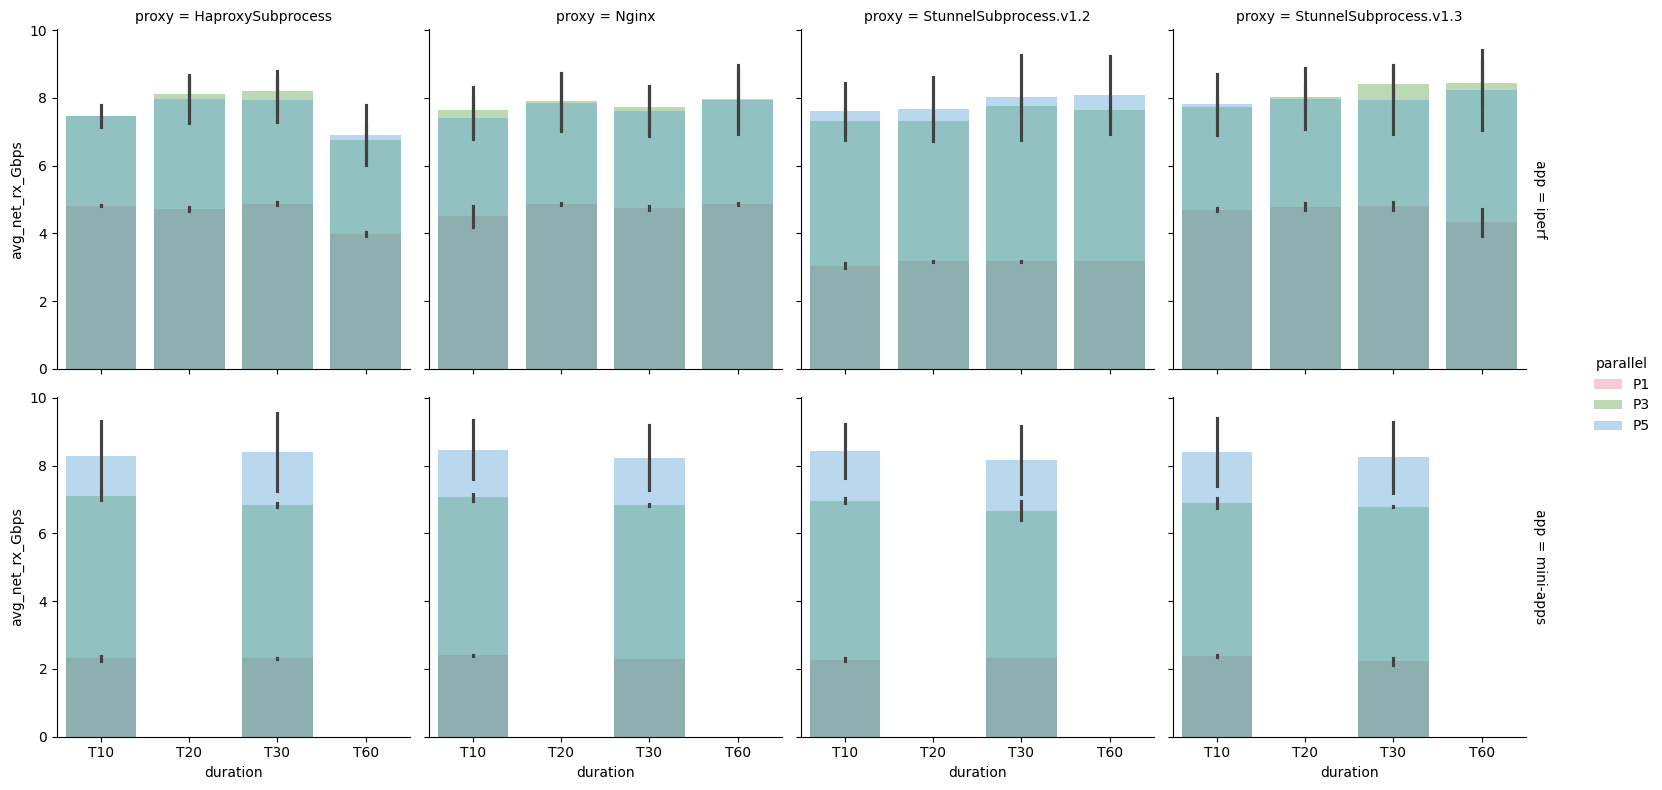

In [31]:
g = sns.FacetGrid(
    agg_config_df,
    row="app", col="proxy", hue="parallel",
    margin_titles=True, height=4, palette="husl"
)
g.map(sns.barplot, "duration", "avg_net_rx_Gbps", order=sorted(agg_config_df["duration"].unique()), alpha=0.4)
g.add_legend()
plt.show()


In [10]:
"""
configs_to_plot = [
    ("HaproxySubprocess", "bbr"),
    ("HaproxySubprocess", "cubic"),
    ("StunnelSubprocess.tls.v1.2", "bbr"),
    ("StunnelSubprocess.tls.v1.2", "cubic"),
    ("StunnelSubprocess.tls.v1.3", "bbr"),   
    ("StunnelSubprocess.tls.v1.3", "cubic"),  
]

labels = []
avg_rx = []

for proxy, congestion in configs_to_plot:
    # str.startswith or strip() 
    subset = agg_config_df[
        (agg_config_df["proxy"] == proxy) &
        (agg_config_df["congestion"] == congestion)
    ]
    if not subset.empty:
        avg_value = subset["avg_net_rx_Gbps"].mean()
        avg_rx.append(avg_value)
    else:
        avg_rx.append(0)
    labels.append(f"{proxy}\n{congestion}")

plt.figure(figsize=(10,6))
bars = plt.bar(labels, avg_rx)
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Avg Net RX Throughput by Proxy & Congestion")
plt.xticks(rotation=15, ha='right')
#plt.tight_layout()
#plt.show()"""


'\nconfigs_to_plot = [\n    ("HaproxySubprocess", "bbr"),\n    ("HaproxySubprocess", "cubic"),\n    ("StunnelSubprocess.tls.v1.2", "bbr"),\n    ("StunnelSubprocess.tls.v1.2", "cubic"),\n    ("StunnelSubprocess.tls.v1.3", "bbr"),   \n    ("StunnelSubprocess.tls.v1.3", "cubic"),  \n]\n\nlabels = []\navg_rx = []\n\nfor proxy, congestion in configs_to_plot:\n    # str.startswith or strip() \n    subset = agg_config_df[\n        (agg_config_df["proxy"] == proxy) &\n        (agg_config_df["congestion"] == congestion)\n    ]\n    if not subset.empty:\n        avg_value = subset["avg_net_rx_Gbps"].mean()\n        avg_rx.append(avg_value)\n    else:\n        avg_rx.append(0)\n    labels.append(f"{proxy}\n{congestion}")\n\nplt.figure(figsize=(10,6))\nbars = plt.bar(labels, avg_rx)\nplt.ylabel("Avg Net RX Throughput (Gbps)")\nplt.title("Avg Net RX Throughput by Proxy & Congestion")\nplt.xticks(rotation=15, ha=\'right\')\n#plt.tight_layout()\n#plt.show()'

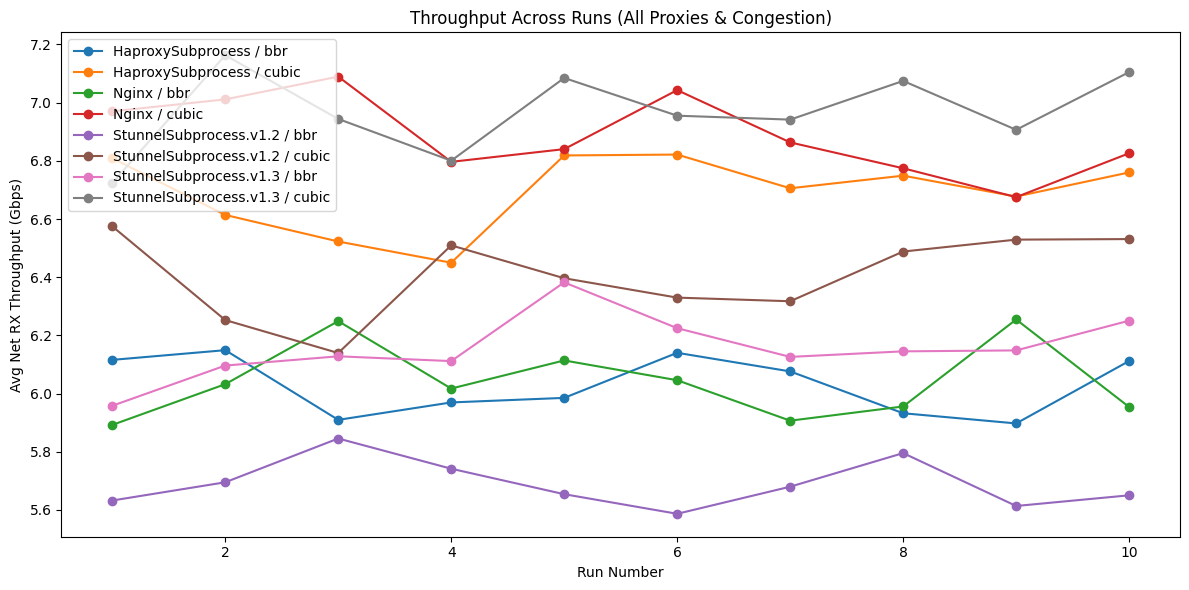

In [32]:
"""
agg_df["run"] = pd.to_numeric(agg_df["run"], errors="coerce")

example_config = {
    "app": "iperf",
    "proxy": "HaproxySubprocess",
    "congestion": "bbr",
    "parallel": "P1",
    "duration": "T10"
}

mask = (
    (agg_df["app"] == example_config["app"]) &
    (agg_df["proxy"] == example_config["proxy"]) &
    (agg_df["congestion"] == example_config["congestion"]) &
    (agg_df["parallel"] == example_config["parallel"]) &
    (agg_df["duration"] == example_config["duration"])
)

per_run = (
    agg_df[mask]
    .groupby("run")["avg_net_rx_Gbps"]
    .mean()
    .reset_index()
    .sort_values("run")
)


plt.figure(figsize=(8,5))
plt.plot(per_run["run"], per_run["avg_net_rx_Gbps"], marker='o', linestyle='-')
plt.xlabel("Run Number")
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Per-Run Throughput (Averaged Over TopN Per Run)")
plt.grid(True)
plt.tight_layout()
plt.show()"""


group_cols = ["proxy", "congestion", "run"]
mean_per_run = (
    agg_df
    .groupby(group_cols)["avg_net_rx_Gbps"]
    .mean()
    .reset_index()
    .sort_values("run")
)

plt.figure(figsize=(12,6))
for (proxy, congestion), group in mean_per_run.groupby(["proxy", "congestion"]):
    plt.plot(
        group["run"], group["avg_net_rx_Gbps"], marker='o', label=f"{proxy} / {congestion}"
    )
plt.xlabel("Run Number")
plt.ylabel("Avg Net RX Throughput (Gbps)")
plt.title("Throughput Across Runs (All Proxies & Congestion)")
plt.legend()
plt.tight_layout()
plt.show()


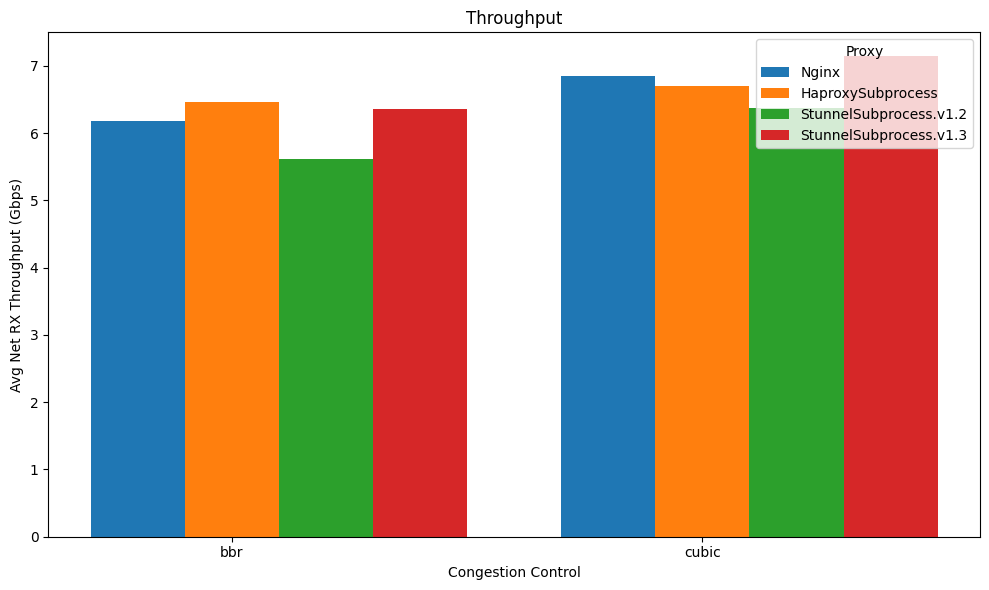

In [15]:

proxies = [
    "Nginx",
    "HaproxySubprocess",
    "StunnelSubprocess.v1.2",
    "StunnelSubprocess.v1.3"
]
congestions = ["bbr", "cubic"]

groups = [
    ("mini-apps", "Nginx"),
    ("mini-apps", "HaproxySubprocess"),
    ("mini-apps", "StunnelSubprocess.v1.2"),
    ("mini-apps", "StunnelSubprocess.v1.3"),
    ("iperf", "Nginx"),
    ("iperf", "HaproxySubprocess"),
    ("iperf", "StunnelSubprocess.v1.2"),
    ("iperf", "StunnelSubprocess.v1.3"),
]

congestions = ["bbr", "cubic"]
colors = ['tab:blue', 'tab:orange']


bar_data = []
for proxy in proxies:
    vals = []
    for congestion in congestions:
        subset = agg_config_df[
            (agg_config_df["proxy"] == proxy) &
            (agg_config_df["congestion"] == congestion)
        ]
        vals.append(subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0)
    bar_data.append(vals)

bar_data = np.array(bar_data) 

bar_width = 0.20
x = np.arange(len(congestions)) 

fig, ax = plt.subplots(figsize=(10,6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, (proxy, color) in enumerate(zip(proxies, colors)):
    ax.bar(x + i * bar_width, bar_data[i], width=bar_width, label=proxy, color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(congestions)
ax.set_ylabel("Avg Net RX Throughput (Gbps)")
ax.set_xlabel("Congestion Control")
ax.set_title("Throughput")
ax.legend(title="Proxy")
plt.tight_layout()
plt.show()


In [33]:
"""rx_bar_data = []
tx_bar_data = []
for proxy in proxies:
    rx_vals, tx_vals = [], []
    for congestion in congestions:
        subset = agg_config_df[
            (agg_config_df["proxy"] == proxy) &
            (agg_config_df["congestion"] == congestion)
        ]
        rx_vals.append(subset["sum_total_rx_dropped"].sum() if not subset.empty else 0)
        tx_vals.append(subset["sum_total_tx_dropped"].sum() if not subset.empty else 0)
    rx_bar_data.append(rx_vals)
    tx_bar_data.append(tx_vals)

rx_bar_data = np.array(rx_bar_data)
tx_bar_data = np.array(tx_bar_data)

bar_width = 0.18
x = np.arange(len(congestions))

fig, ax = plt.subplots(figsize=(12,6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, (proxy, color) in enumerate(zip(proxies, colors)):
    ax.bar(x + i * 2 * bar_width, rx_bar_data[i], width=bar_width, label=f"{proxy} RX", color=color, alpha=0.7)
    ax.bar(x + i * 2 * bar_width + bar_width, tx_bar_data[i], width=bar_width, label=f"{proxy} TX", color=color, hatch='//', alpha=0.7)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(congestions)
ax.set_ylabel("Retransmissions (sum)")
ax.set_xlabel("Congestion Control")
ax.set_title("RX & TX (Retransmissions")
ax.legend(title="Legend", ncol=2)
plt.tight_layout()
plt.show()"""


'rx_bar_data = []\ntx_bar_data = []\nfor proxy in proxies:\n    rx_vals, tx_vals = [], []\n    for congestion in congestions:\n        subset = agg_config_df[\n            (agg_config_df["proxy"] == proxy) &\n            (agg_config_df["congestion"] == congestion)\n        ]\n        rx_vals.append(subset["sum_total_rx_dropped"].sum() if not subset.empty else 0)\n        tx_vals.append(subset["sum_total_tx_dropped"].sum() if not subset.empty else 0)\n    rx_bar_data.append(rx_vals)\n    tx_bar_data.append(tx_vals)\n\nrx_bar_data = np.array(rx_bar_data)\ntx_bar_data = np.array(tx_bar_data)\n\nbar_width = 0.18\nx = np.arange(len(congestions))\n\nfig, ax = plt.subplots(figsize=(12,6))\ncolors = [\'tab:blue\', \'tab:orange\', \'tab:green\']\n\nfor i, (proxy, color) in enumerate(zip(proxies, colors)):\n    ax.bar(x + i * 2 * bar_width, rx_bar_data[i], width=bar_width, label=f"{proxy} RX", color=color, alpha=0.7)\n    ax.bar(x + i * 2 * bar_width + bar_width, tx_bar_data[i], width=bar_width,

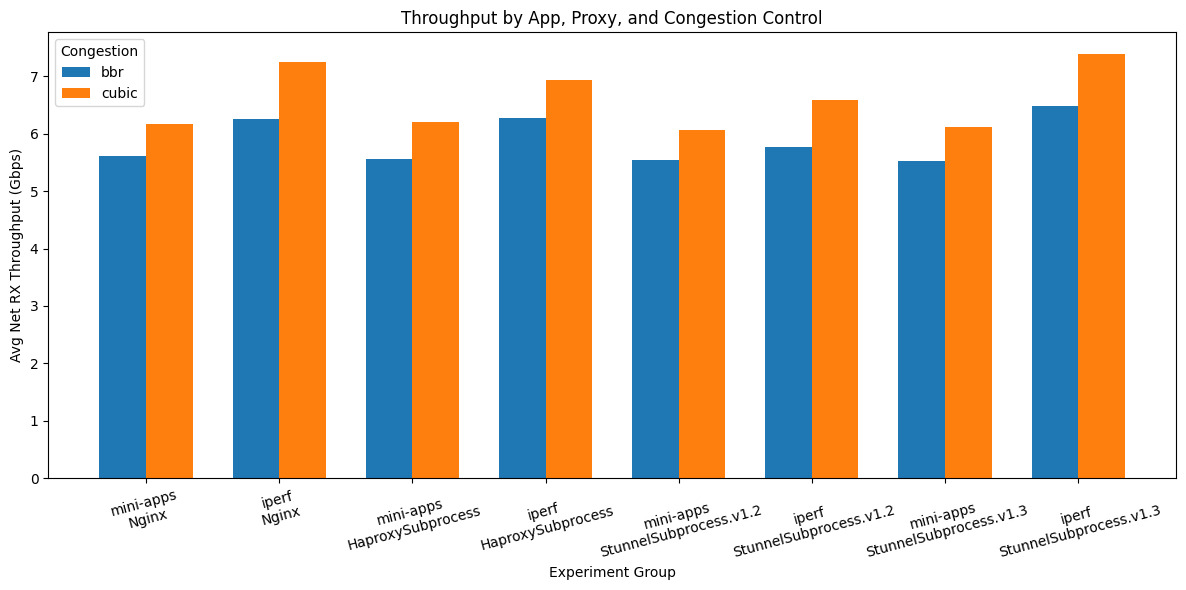

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define groups as tuples: (app, proxy)
"""groups = [
    ("mini-apps", "Nginx"),
    ("mini-apps", "HaproxySubprocess"),
    ("mini-apps", "StunnelSubprocess.v1.2"),
    ("mini-apps", "StunnelSubprocess.v1.3"),
    ("iperf", "Nginx"),
    ("iperf", "HaproxySubprocess"),
    ("iperf", "StunnelSubprocess.v1.2"),
    ("iperf", "StunnelSubprocess.v1.3"),
]"""
groups = [
    ("mini-apps", "Nginx"),
    ("iperf", "Nginx"),
    
    ("mini-apps", "HaproxySubprocess"),
    ("iperf", "HaproxySubprocess"),
    
    ("mini-apps", "StunnelSubprocess.v1.2"),
    ("iperf", "StunnelSubprocess.v1.2"),
    
    ("mini-apps", "StunnelSubprocess.v1.3"),
    ("iperf", "StunnelSubprocess.v1.3"),
]

congestions = ["bbr", "cubic"]
colors = ['tab:blue', 'tab:orange']

bar_width = 0.35
x = np.arange(len(groups))

# Prepare bar heights
bbr_vals, cubic_vals = [], []
for app, proxy in groups:
    for congestion in congestions:
        subset = agg_config_df[
            (agg_config_df["app"] == app) &
            (agg_config_df["proxy"] == proxy) &
            (agg_config_df["congestion"] == congestion)
        ]
        value = subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0
        if congestion == "bbr":
            bbr_vals.append(value)
        else:
            cubic_vals.append(value)

fig, ax = plt.subplots(figsize=(12,6))

# Plot bars side-by-side for each group
ax.bar(x - bar_width/2, bbr_vals, width=bar_width, color=colors[0], label='bbr')
ax.bar(x + bar_width/2, cubic_vals, width=bar_width, color=colors[1], label='cubic')

# Make x-tick labels as "app\nproxy"
xtick_labels = [f"{app}\n{proxy}" for (app, proxy) in groups]
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=15, ha='center')

ax.set_ylabel("Avg Net RX Throughput (Gbps)")
ax.set_xlabel("Experiment Group")
ax.set_title("Throughput by App, Proxy, and Congestion Control")
ax.legend(title="Congestion")
plt.tight_layout()
plt.show()


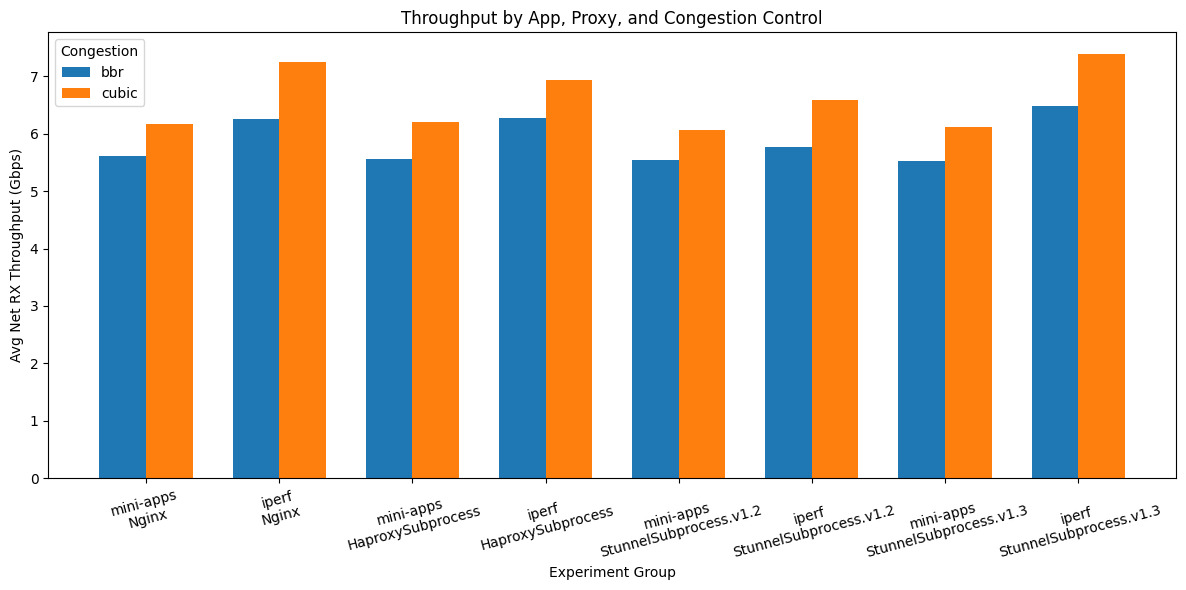

In [35]:
apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = ["bbr", "cubic"]

bar_values = []
labels = []
for proxy in proxies:
    for congestion in congestions:
        for app in apps:
            subset = agg_config_df[
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == congestion) &
                (agg_config_df["app"] == app)
            ]
            value = subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0
            bar_values.append(value)
            labels.append(f"{proxy}-{app}-{congestion}")
            

fig, ax = plt.subplots(figsize=(12,6))


# Plot bars side-by-side for each group
ax.bar(x - bar_width/2, bbr_vals, width=bar_width, color=colors[0], label='bbr')
ax.bar(x + bar_width/2, cubic_vals, width=bar_width, color=colors[1], label='cubic')

# Make x-tick labels as "app\nproxy"
xtick_labels = [f"{app}\n{proxy}" for (app, proxy) in groups]
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=15, ha='center')

ax.set_ylabel("Avg Net RX Throughput (Gbps)")
ax.set_xlabel("Experiment Group")
ax.set_title("Throughput by App, Proxy, and Congestion Control")
ax.legend(title="Congestion")
plt.tight_layout()
plt.show()

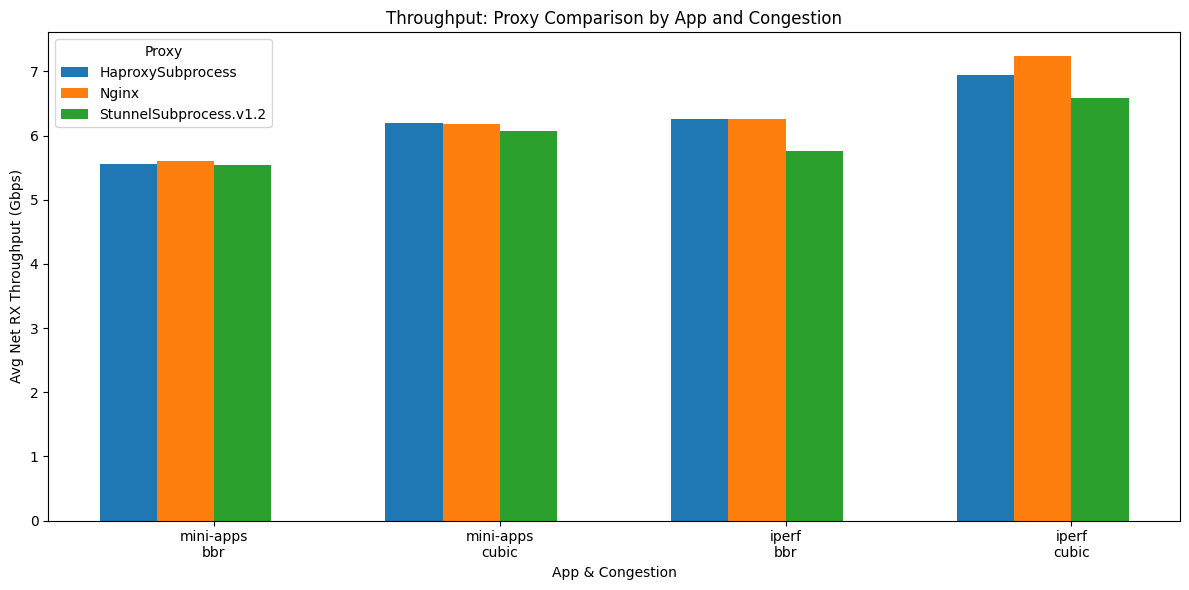

In [37]:
import matplotlib.pyplot as plt
import numpy as np

apps = ["mini-apps", "iperf"]
congestions = ["bbr", "cubic"]
"""proxies = [
    "Nginx",
    "HaproxySubprocess",
    "StunnelSubprocess.v1.2",
    "StunnelSubprocess.v1.3"
]"""
proxies = agg_config_df["proxy"].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green']

# All group combinations
groups = [(app, cong) for app in apps for cong in congestions]
n_groups = len(groups)
n_proxies = len(proxies)
bar_width = 0.2
x = np.arange(n_groups)  # group locations

# Prepare bar heights: shape [n_proxies, n_groups]
bar_data = np.zeros((n_proxies, n_groups))
for group_idx, (app, cong) in enumerate(groups):
    for proxy_idx, proxy in enumerate(proxies):
        subset = agg_config_df[
            (agg_config_df["app"] == app) &
            (agg_config_df["congestion"] == cong) &
            (agg_config_df["proxy"] == proxy)
        ]
        bar_data[proxy_idx, group_idx] = subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0

# Plot
fig, ax = plt.subplots(figsize=(12,6))
for proxy_idx, (proxy, color) in enumerate(zip(proxies, colors)):
    ax.bar(
        x + proxy_idx * bar_width,
        bar_data[proxy_idx],
        width=bar_width,
        label=proxy,
        color=color
    )

# X-tick labels: app\ncongestion
xtick_labels = [f"{app}\n{cong}" for (app, cong) in groups]
ax.set_xticks(x + (n_proxies-1) * bar_width / 2)
ax.set_xticklabels(xtick_labels, rotation=0)

ax.set_ylabel("Avg Net RX Throughput (Gbps)")
ax.set_xlabel("App & Congestion")
ax.set_title("Throughput: Proxy Comparison by App and Congestion")
ax.legend(title="Proxy")
plt.tight_layout()
plt.show()


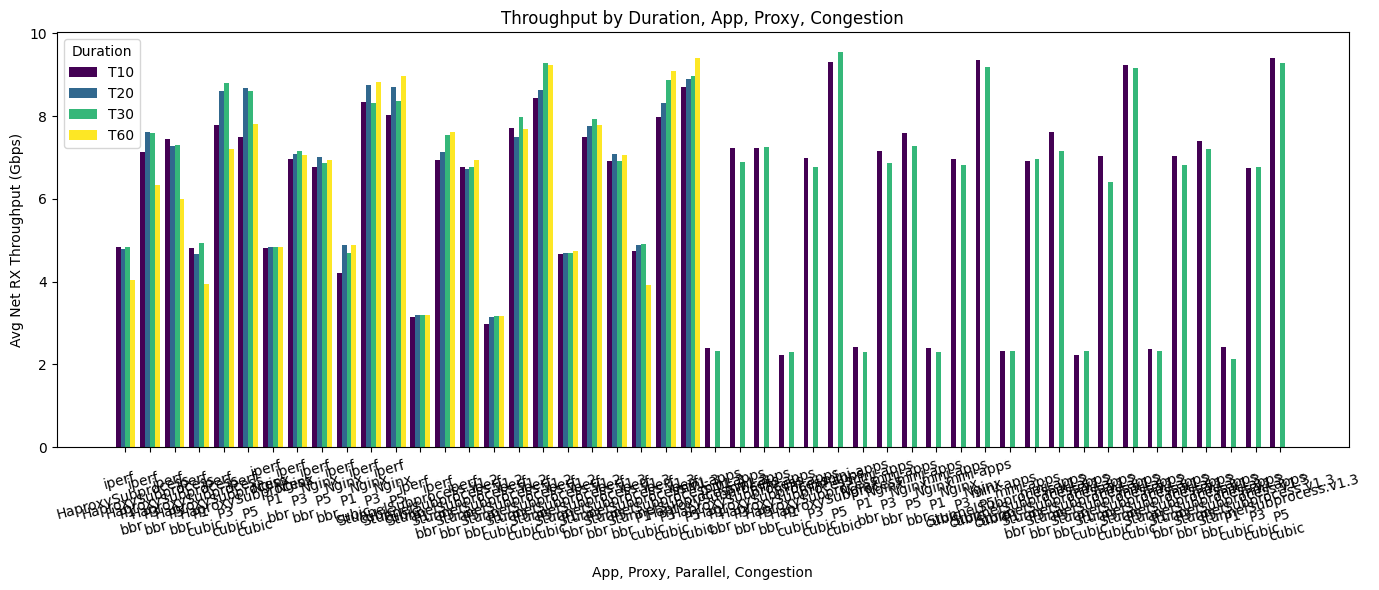

In [38]:
durations = sorted(agg_config_df["duration"].unique(), key=lambda x: int(x[1:]))

group_cols = ['app', 'proxy', 'parallel','congestion']
groups = agg_config_df[group_cols].drop_duplicates().values.tolist()

bar_data = np.zeros((len(durations), len(groups)))
for group_idx, (app, proxy, parallel, congestion) in enumerate(groups):
    for dur_idx, duration in enumerate(durations):
        subset = agg_config_df[
            (agg_config_df["app"] == app) &
            (agg_config_df["proxy"] == proxy) &
            (agg_config_df["parallel"] == parallel) &
            (agg_config_df["congestion"] == congestion) &
            (agg_config_df["duration"] == duration)
        ]
        bar_data[dur_idx, group_idx] = subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0

import matplotlib.pyplot as plt
import numpy as np

n_groups = len(groups)
n_durations = len(durations)
bar_width = 0.8 / n_durations   # Make bars not overflow
x = np.arange(n_groups)
duration_colors = plt.cm.viridis(np.linspace(0, 1, n_durations))  # or use your own color list

fig, ax = plt.subplots(figsize=(14, 6))

for dur_idx, duration in enumerate(durations):
    ax.bar(
        x + dur_idx * bar_width,
        bar_data[dur_idx],
        width=bar_width,
        label=duration,
        color=duration_colors[dur_idx]
    )


xtick_labels = [f"{app}\n{proxy}\n{parallel}\n{congestion}" for (app, proxy, parallel, congestion) in groups]
ax.set_xticks(x + bar_width * (n_durations - 1) / 2)
ax.set_xticklabels(xtick_labels, rotation=15, ha='center')

ax.set_ylabel("Avg Net RX Throughput (Gbps)")
ax.set_xlabel("App, Proxy, Parallel, Congestion")
ax.set_title("Throughput by Duration, App, Proxy, Congestion")
ax.legend(title="Duration")
plt.tight_layout()
plt.show()



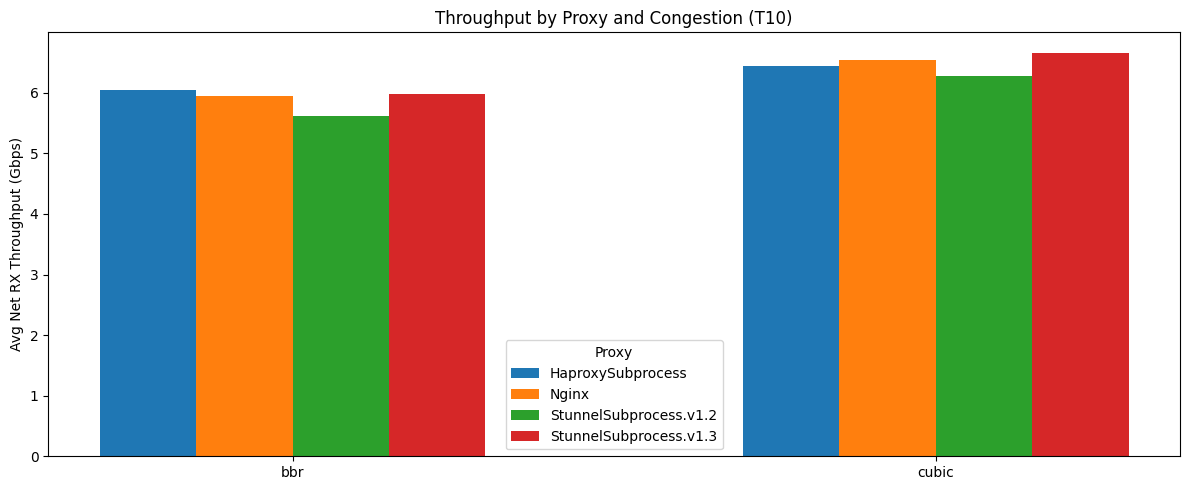

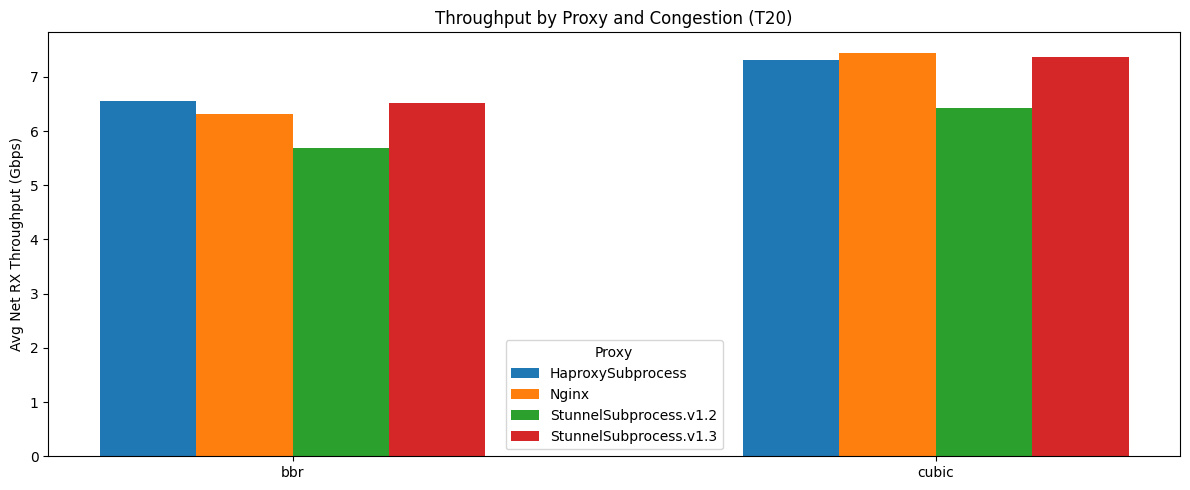

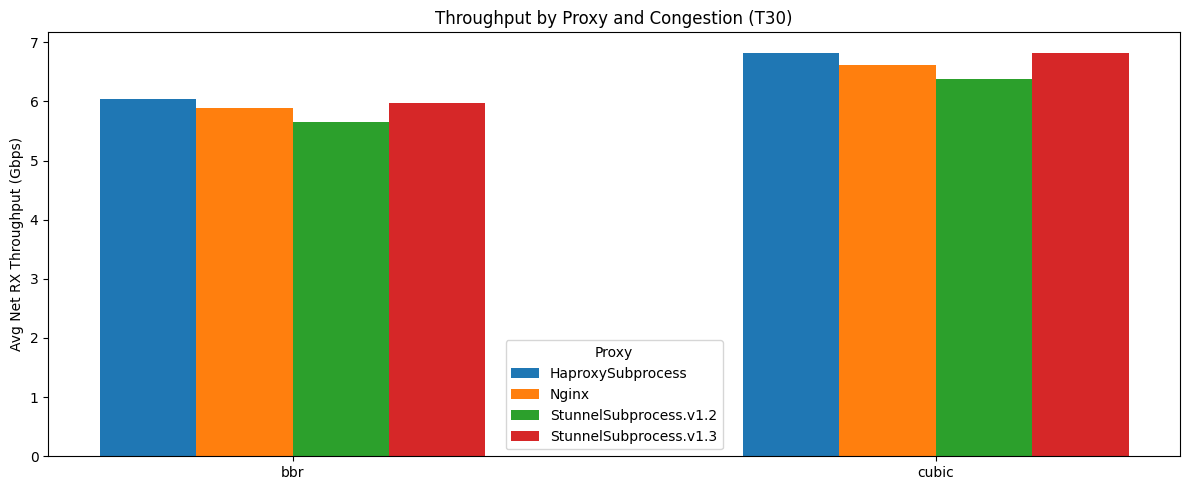

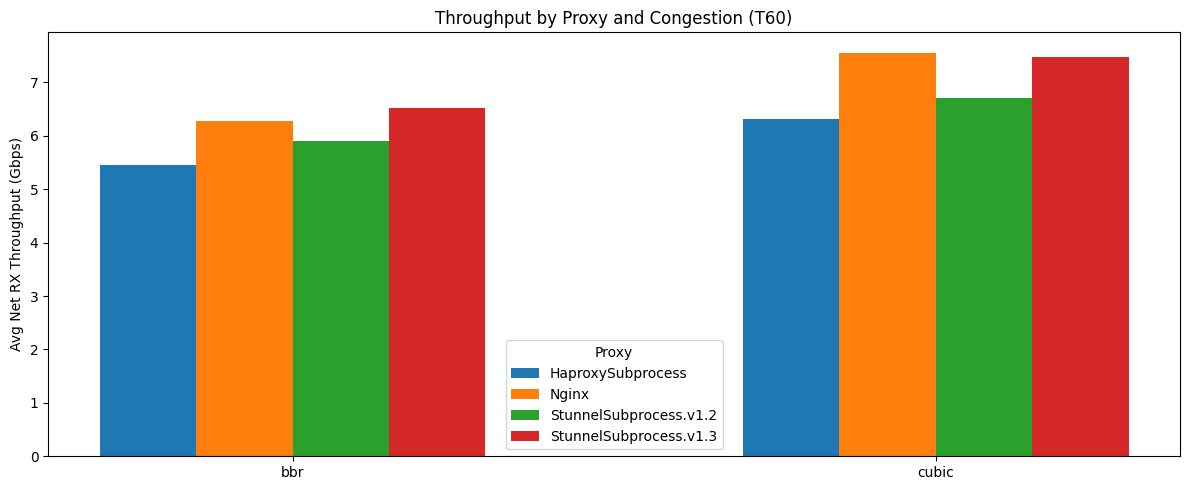

In [45]:

durations = sorted(agg_config_df["duration"].unique(), key=lambda x: int(x[1:]))
parallels = sorted(agg_config_df["parallel"].unique(), key=lambda x: int(x[1:]))
apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()

proxy_colors = dict(zip(proxies, plt.cm.tab10.colors)) 

for duration in durations:
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(congestions))
    bar_width = 0.15
    for i, proxy in enumerate(proxies):
        heights = []
        for congestion in congestions:
            subset = agg_config_df[
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == congestion) &
                (agg_config_df["duration"] == duration)
            ]
            heights.append(subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0)
        ax.bar(x + i*bar_width, heights, width=bar_width, label=proxy, color=proxy_colors[proxy])
    ax.set_xticks(x + bar_width * (len(proxies)-1)/2)
    ax.set_xticklabels(congestions)
    ax.set_ylabel("Avg Net RX Throughput (Gbps)")
    ax.set_title(f"Throughput by Proxy and Congestion ({duration})")
    ax.legend(title="Proxy")
    plt.tight_layout()
    plt.show()


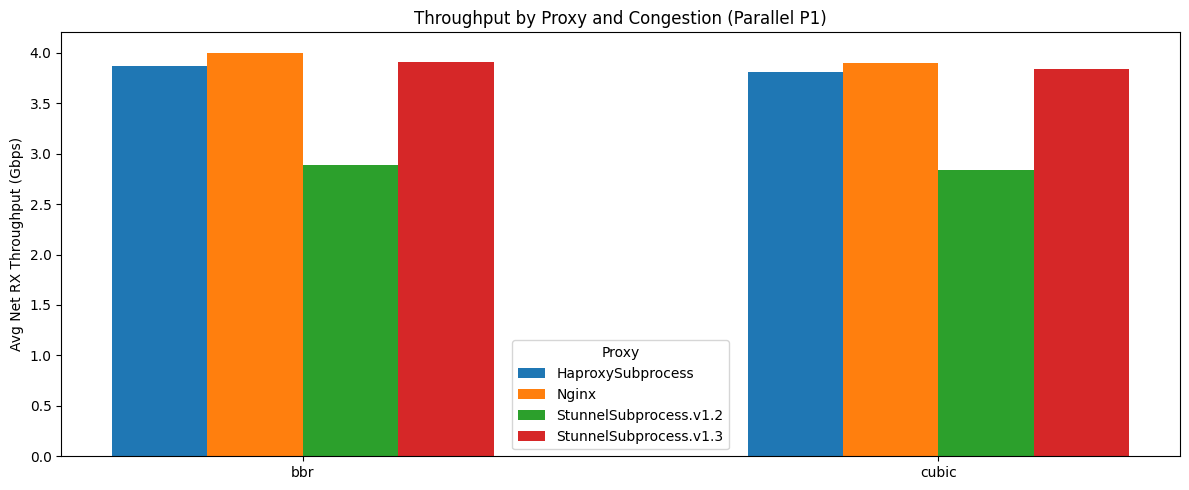

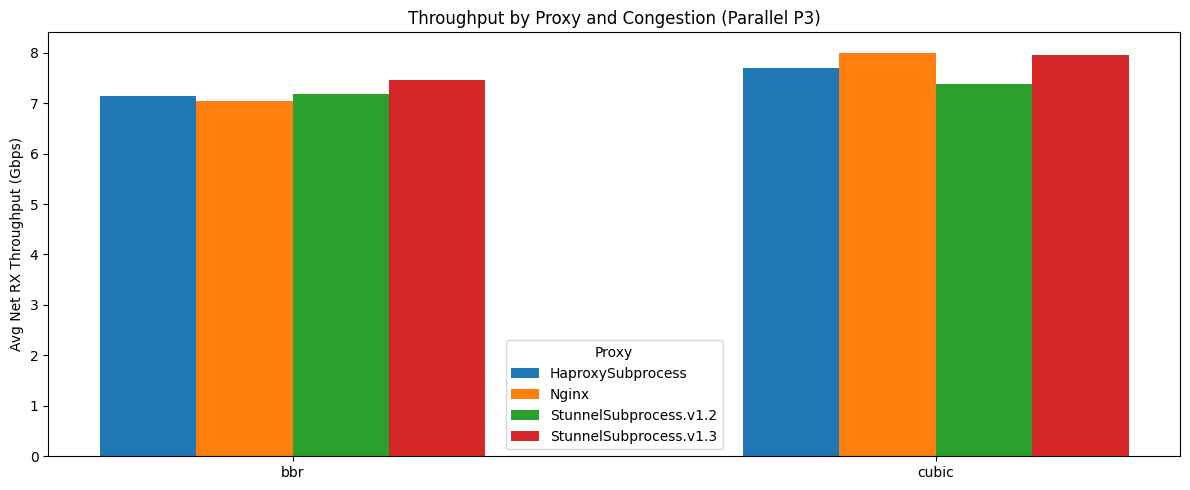

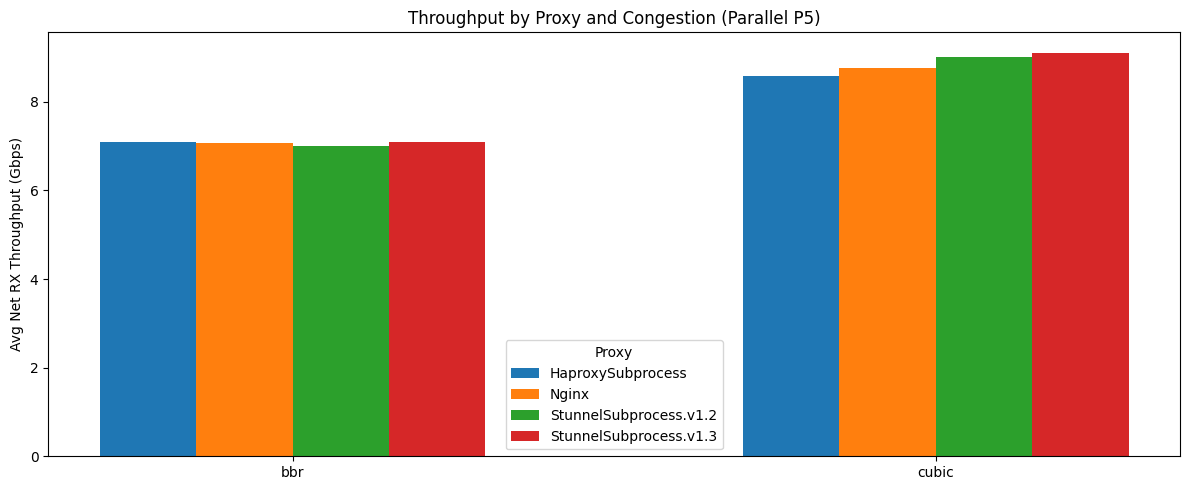

In [ ]:
parallels = sorted(agg_config_df["parallel"].unique(), key=lambda x: int(x[1:]))
apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()

for parallel in parallels:
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(congestions))
    bar_width = 0.15
    for i, proxy in enumerate(proxies):
        heights = []
        for congestion in congestions:
            subset = agg_config_df[
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == congestion) &
                (agg_config_df["parallel"] == parallel)
            ]
            heights.append(subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0)
        ax.bar(x + i*bar_width, heights, width=bar_width, label=proxy, color=proxy_colors[proxy])
    ax.set_xticks(x + bar_width * (len(proxies)-1)/2)
    ax.set_xticklabels(congestions)
    ax.set_ylabel("Avg Net RX Throughput (Gbps)")
    ax.set_title(f"Throughput by Proxy and Congestion (Parallel {parallel})")
    ax.legend(title="Proxy")
    plt.tight_layout()
    plt.show()


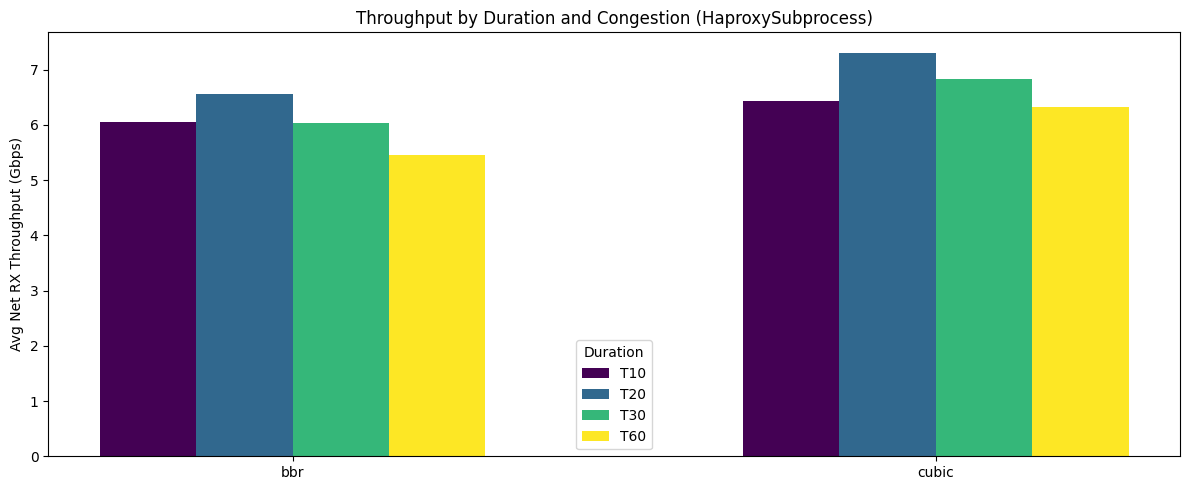

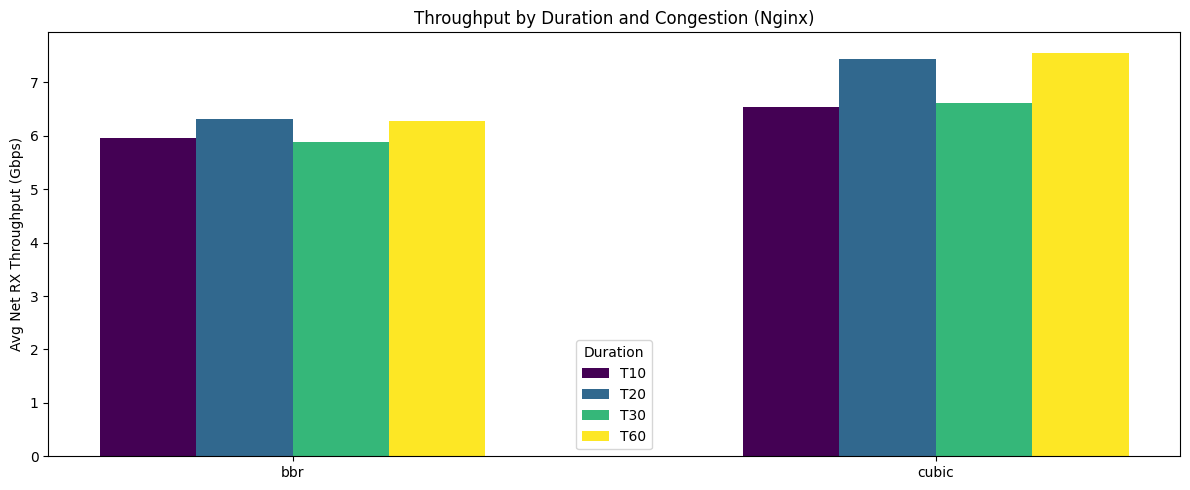

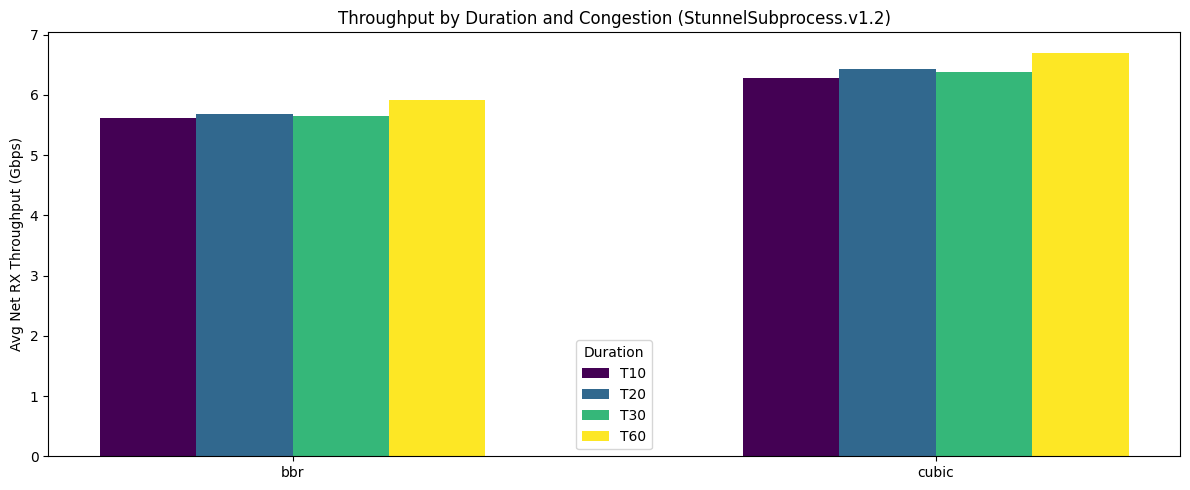

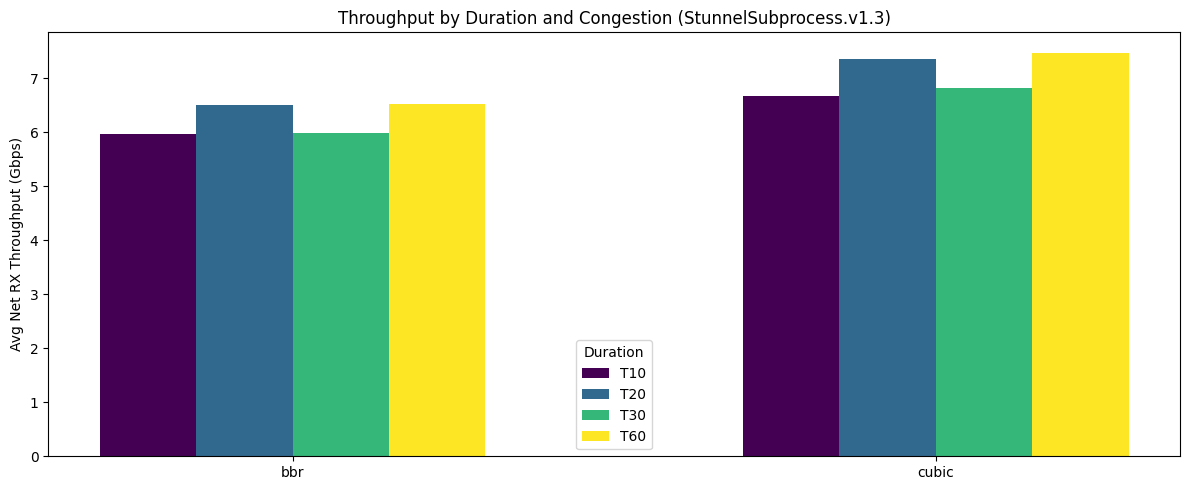

In [41]:
duration_colors = dict(zip(durations, plt.cm.viridis(np.linspace(0,1,len(durations)))))

for proxy in proxies:
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(congestions))
    bar_width = 0.15
    for i, duration in enumerate(durations):
        heights = []
        for congestion in congestions:
            subset = agg_config_df[
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == congestion) &
                (agg_config_df["duration"] == duration)
            ]
            heights.append(subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0)
        ax.bar(x + i*bar_width, heights, width=bar_width, label=duration, color=duration_colors[duration])
    ax.set_xticks(x + bar_width * (len(durations)-1)/2)
    ax.set_xticklabels(congestions)
    ax.set_ylabel("Avg Net RX Throughput (Gbps)")
    ax.set_title(f"Throughput by Duration and Congestion ({proxy})")
    ax.legend(title="Duration")
    plt.tight_layout()
    plt.show()


---------------

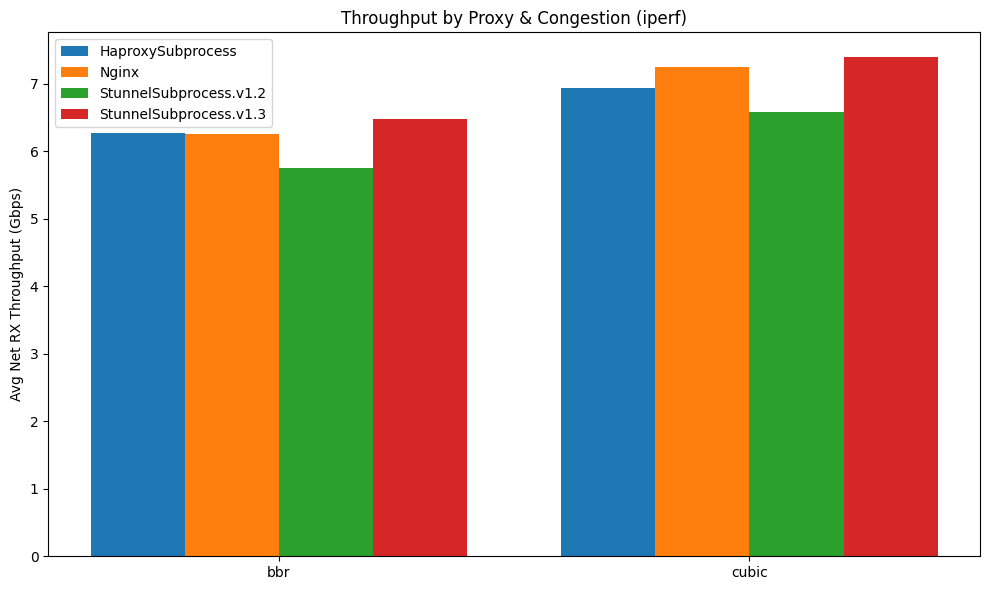

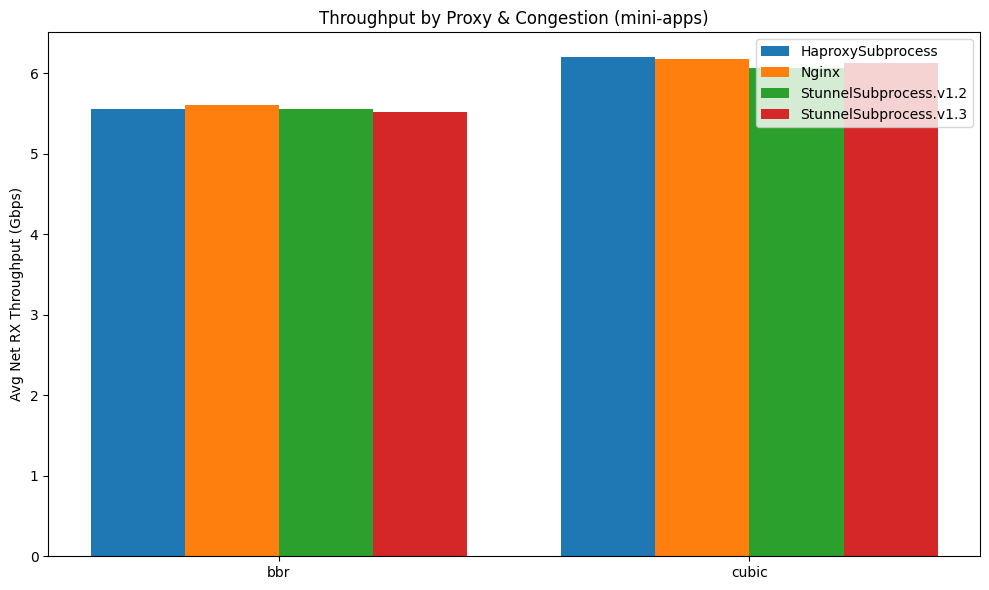

In [42]:

apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()

for app in apps:
    fig, ax = plt.subplots(figsize=(10,6))
    bar_width = 0.2
    x = np.arange(len(congestions))
    for i, proxy in enumerate(proxies):
        vals = []
        for cong in congestions:
            subset = agg_config_df[
                (agg_config_df["app"] == app) &
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == cong)
            ]
            vals.append(subset["avg_net_rx_Gbps"].mean() if not subset.empty else 0)
        ax.bar(x + i*bar_width, vals, width=bar_width, label=proxy)
    ax.set_xticks(x + bar_width*(len(proxies)-1)/2)
    ax.set_xticklabels(congestions)
    ax.set_ylabel("Avg Net RX Throughput (Gbps)")
    ax.set_title(f"Throughput by Proxy & Congestion ({app})")
    ax.legend()
    plt.tight_layout()
    plt.show()

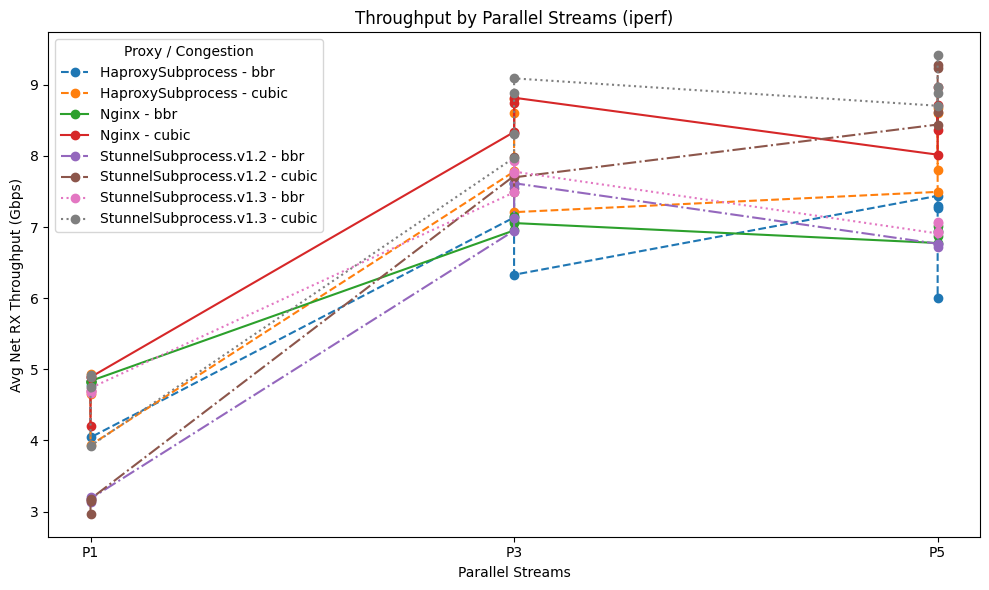

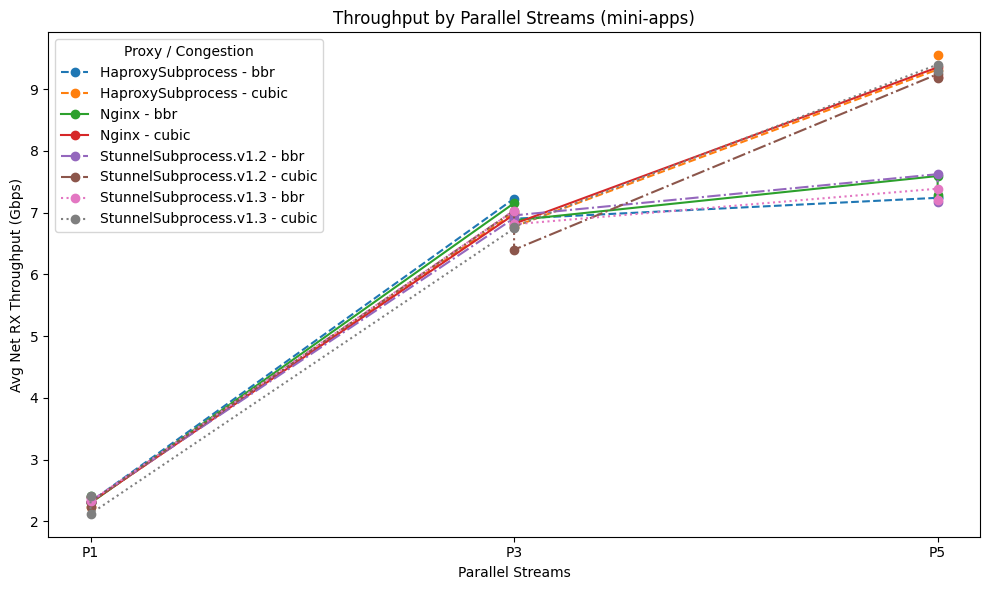

In [43]:
"""for app in apps:
    for proxy in proxies:
        fig, ax = plt.subplots(figsize=(6,4))
        for cong in congestions:
            subset = agg_config_df[
                (agg_config_df["app"] == app) &
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == cong)
            ]
            if not subset.empty:
                ax.plot(
                    subset["parallel"], subset["avg_net_rx_Gbps"], 
                    marker='o', label=f"{cong}"
                )
        ax.set_xlabel("Parallel Streams")
        ax.set_ylabel("Avg Net RX Throughput (Gbps)")
        ax.set_title(f"Throughput by Parallel Streams ({app}, {proxy})")
        ax.legend(title="Congestion")
        plt.tight_layout()
        plt.show()"""


apps = agg_config_df["app"].unique()
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()

# different line style to each proxy
proxy_linestyles = {
    "Nginx": '-',
    "HaproxySubprocess": '--',
    "StunnelSubprocess.v1.2": '-.',
    "StunnelSubprocess.v1.3": ':'
}

for app in apps:
    fig, ax = plt.subplots(figsize=(10, 6))
    for proxy in proxies:
        linestyle = proxy_linestyles.get(proxy, '-')
        for cong in congestions:
            subset = agg_config_df[
                (agg_config_df["app"] == app) &
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == cong)
            ].sort_values("parallel")
            if not subset.empty:
                ax.plot(
                    subset["parallel"], subset["avg_net_rx_Gbps"],
                    marker='o',
                    linestyle=linestyle,
                    label=f"{proxy} - {cong}"
                )
    ax.set_xlabel("Parallel Streams")
    ax.set_ylabel("Avg Net RX Throughput (Gbps)")
    ax.set_title(f"Throughput by Parallel Streams ({app})")
    ax.legend(title="Proxy / Congestion")
    plt.tight_layout()
    plt.show()


In [60]:
"""for app in apps:
    for proxy in proxies:
        for cong in congestions:
            subset = agg_config_df[
                (agg_config_df["app"] == app) &
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == cong)
            ]
            if not subset.empty:
                plt.figure(figsize=(8,4))
                plt.plot(
                    subset["duration"].apply(lambda x: int(x[1:])), 
                    subset["avg_net_rx_Gbps"], marker='o'
                )
                plt.xlabel("Duration (seconds)")
                plt.ylabel("Avg Net RX Throughput (Gbps)")
                plt.title(f"Throughput vs Duration ({app}, {proxy}, {cong})")
                plt.tight_layout()
                plt.show()"""


'for app in apps:\n    for proxy in proxies:\n        for cong in congestions:\n            subset = agg_config_df[\n                (agg_config_df["app"] == app) &\n                (agg_config_df["proxy"] == proxy) &\n                (agg_config_df["congestion"] == cong)\n            ]\n            if not subset.empty:\n                plt.figure(figsize=(8,4))\n                plt.plot(\n                    subset["duration"].apply(lambda x: int(x[1:])), \n                    subset["avg_net_rx_Gbps"], marker=\'o\'\n                )\n                plt.xlabel("Duration (seconds)")\n                plt.ylabel("Avg Net RX Throughput (Gbps)")\n                plt.title(f"Throughput vs Duration ({app}, {proxy}, {cong})")\n                plt.tight_layout()\n                plt.show()'

In [61]:
"""for app in apps:
    fig, ax = plt.subplots(figsize=(10,6))
    bar_width = 0.2
    x = np.arange(len(congestions))
    for i, proxy in enumerate(proxies):
        vals = []
        for cong in congestions:
            subset = agg_config_df[
                (agg_config_df["app"] == app) &
                (agg_config_df["proxy"] == proxy) &
                (agg_config_df["congestion"] == cong)
            ]
            vals.append(subset["sum_total_rx_dropped"].sum() if not subset.empty else 0)
        ax.bar(x + i*bar_width, vals, width=bar_width, label=proxy)
    ax.set_xticks(x + bar_width*(len(proxies)-1)/2)
    ax.set_xticklabels(congestions)
    ax.set_ylabel("Total RX Retransmissions")
    ax.set_title(f"Retransmissions by Proxy & Congestion ({app})")
    ax.legend()
    plt.tight_layout()
    plt.show()"""


'for app in apps:\n    fig, ax = plt.subplots(figsize=(10,6))\n    bar_width = 0.2\n    x = np.arange(len(congestions))\n    for i, proxy in enumerate(proxies):\n        vals = []\n        for cong in congestions:\n            subset = agg_config_df[\n                (agg_config_df["app"] == app) &\n                (agg_config_df["proxy"] == proxy) &\n                (agg_config_df["congestion"] == cong)\n            ]\n            vals.append(subset["sum_total_rx_dropped"].sum() if not subset.empty else 0)\n        ax.bar(x + i*bar_width, vals, width=bar_width, label=proxy)\n    ax.set_xticks(x + bar_width*(len(proxies)-1)/2)\n    ax.set_xticklabels(congestions)\n    ax.set_ylabel("Total RX Retransmissions")\n    ax.set_title(f"Retransmissions by Proxy & Congestion ({app})")\n    ax.legend()\n    plt.tight_layout()\n    plt.show()'

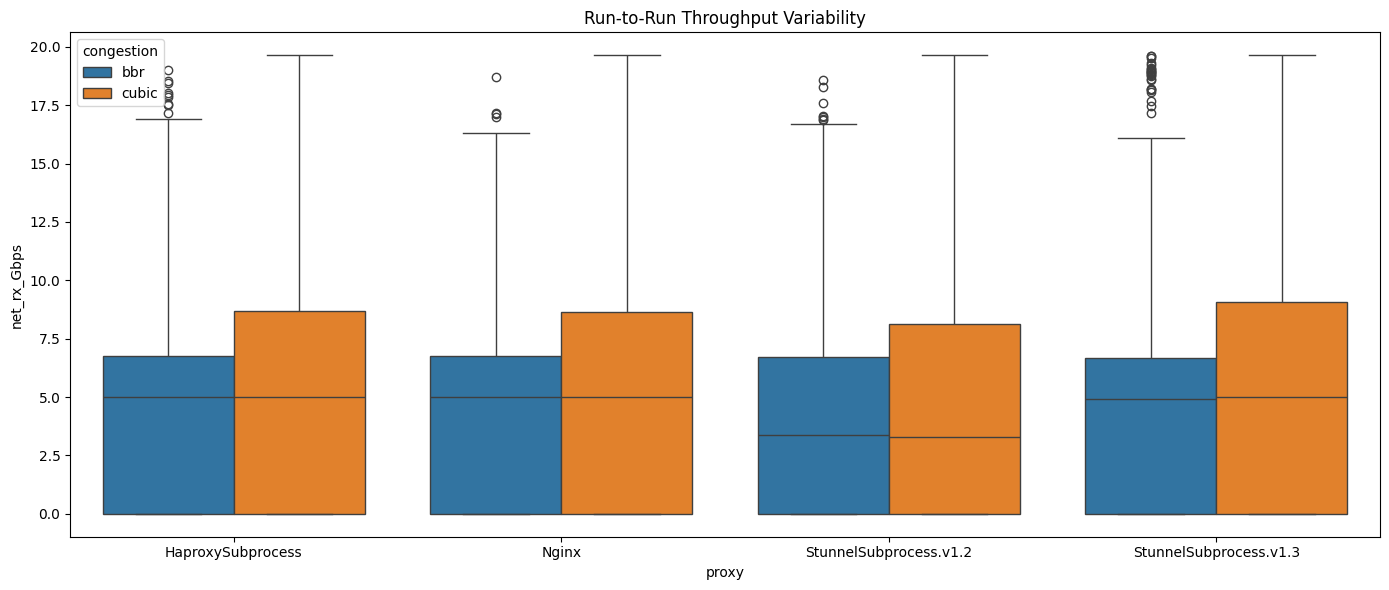

In [44]:

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df, 
    x="proxy", 
    y="net_rx_Gbps", 
    hue="congestion"
)
plt.title("Run-to-Run Throughput Variability")
plt.tight_layout()
plt.show()


In [58]:
"""plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df, 
    x="proxy", 
    y="total_rx_dropped", 
    hue="congestion"
)
plt.title("Run-to-Run Retransmission Variability")
plt.tight_layout()
plt.show()
"""

'plt.figure(figsize=(14, 6))\nsns.boxplot(\n    data=df, \n    x="proxy", \n    y="total_rx_dropped", \n    hue="congestion"\n)\nplt.title("Run-to-Run Retransmission Variability")\nplt.tight_layout()\nplt.show()\n'

In [59]:

"""run_subset = df[
    (df["app"] == "mini-apps") & 
    (df["proxy"] == "Nginx") & 
    (df["congestion"] == "bbr") &
    (df["run"] == 10)
]
plt.plot(run_subset["timestamp"], run_subset["net_rx_Gbps"])
plt.xlabel("Time")
plt.ylabel("Net RX Throughput (Gbps)")
plt.title("Throughput Over Time (Example Run)")
plt.tight_layout()
plt.show()
"""

'run_subset = df[\n    (df["app"] == "mini-apps") & \n    (df["proxy"] == "Nginx") & \n    (df["congestion"] == "bbr") &\n    (df["run"] == 10)\n]\nplt.plot(run_subset["timestamp"], run_subset["net_rx_Gbps"])\nplt.xlabel("Time")\nplt.ylabel("Net RX Throughput (Gbps)")\nplt.title("Throughput Over Time (Example Run)")\nplt.tight_layout()\nplt.show()\n'

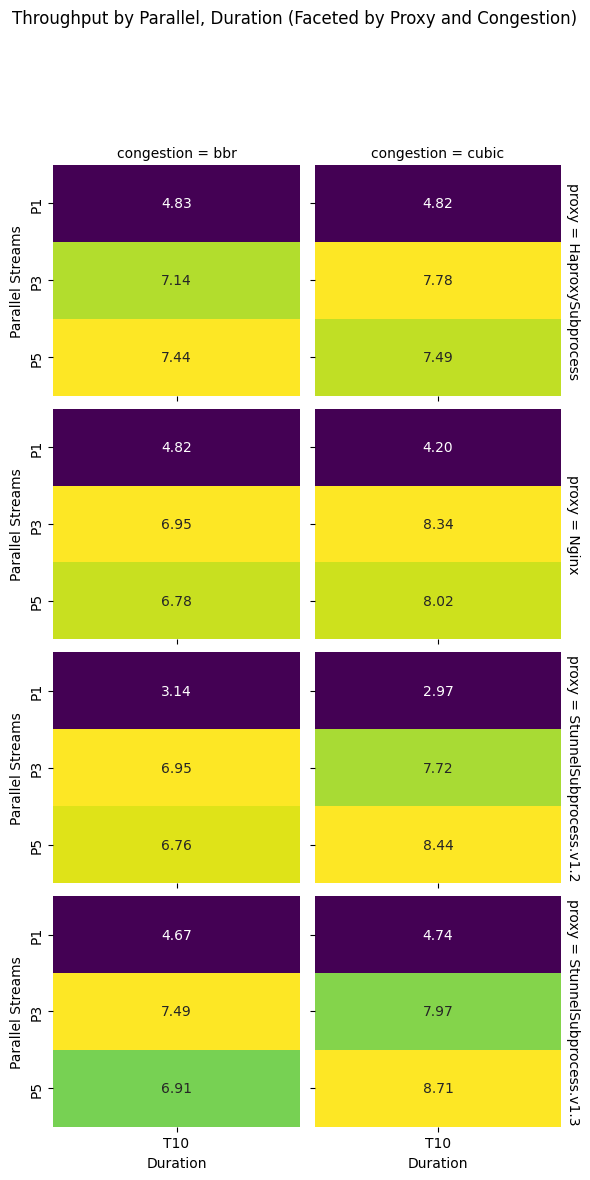

In [ ]:


# (Optional) Sort or filter your DataFrame as needed
# agg_config_df = agg_config_df[agg_config_df["app"] == "mini-apps"] # example

# Create a column with combined label for faceting (optional, or use row/col separately)
agg_config_df["facet"] = agg_config_df["proxy"] + "\n" + agg_config_df["congestion"]

# Get all unique proxies and congestions for faceting
proxies = agg_config_df["proxy"].unique()
congestions = agg_config_df["congestion"].unique()

# Set up the FacetGrid
g = sns.FacetGrid(
    agg_config_df,
    row="proxy", col="congestion",
    margin_titles=True, height=3,
    sharex=True, sharey=True
)

# Define a function to draw a heatmap on each facet
def draw_heatmap(data, **kwargs):
    pivot = data.pivot_table(
        index="parallel", columns="duration", values="avg_net_rx_Gbps", aggfunc="mean"
    )
    sns.heatmap(
        pivot,
        annot=True, fmt=".2f", cmap="viridis",
        cbar=False,  # Only add colorbar to one facet for clarity
        **kwargs
    )

# Map the function onto the FacetGrid
g.map_dataframe(draw_heatmap)

# Set overall title and axis labels
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Throughput by Parallel, Duration (Faceted by Proxy and Congestion)")
g.set_axis_labels("Duration", "Parallel Streams")
plt.show()


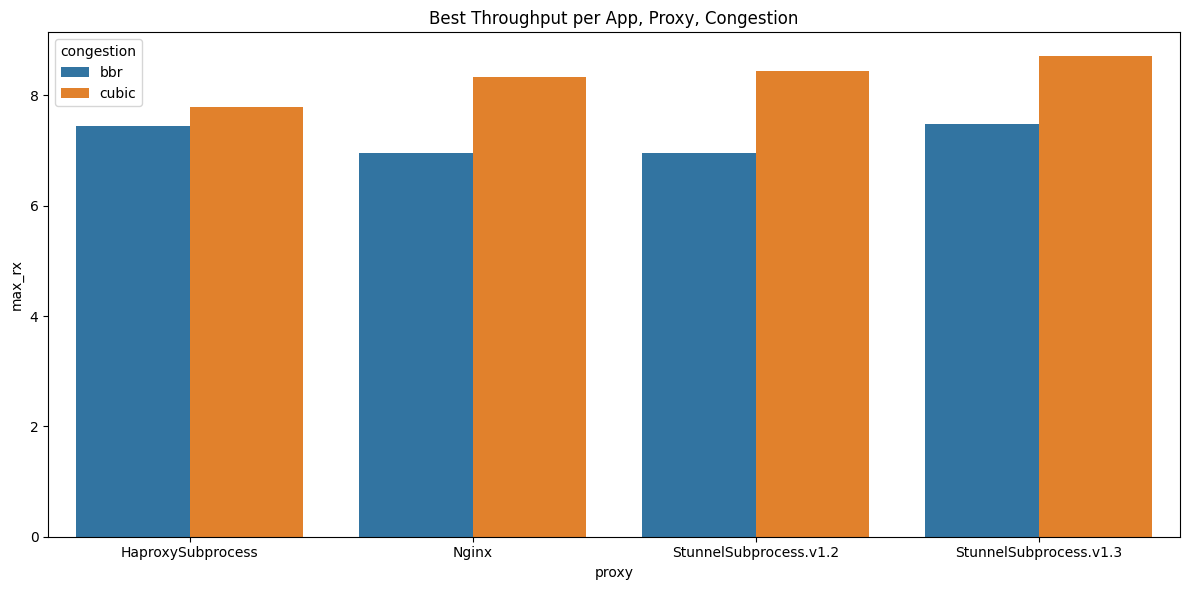

In [40]:
best_df = (
    agg_config_df
    .groupby(['app', 'proxy', 'congestion'])
    .agg(max_rx=('avg_net_rx_Gbps', 'max'))
    .reset_index()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=best_df, 
    x="proxy", y="max_rx", hue="congestion"
)
plt.title("Best Throughput per App, Proxy, Congestion")
plt.tight_layout()
plt.show()


In [41]:
summary = (
    agg_config_df
    .groupby(['app', 'proxy', 'congestion'])
    .agg(
        mean_rx=('avg_net_rx_Gbps', 'mean'),
        mean_retrans=('sum_total_rx_dropped', 'mean'),
        max_cpu=('max_total_cpu', 'max')
    )
    .reset_index()
)
print(summary)


     app                   proxy congestion   mean_rx  mean_retrans  max_cpu
0  iperf       HaproxySubprocess        bbr  6.466767           0.0     1.60
1  iperf       HaproxySubprocess      cubic  6.697133           0.0     1.50
2  iperf                   Nginx        bbr  6.181267           0.0     1.32
3  iperf                   Nginx      cubic  6.850167           0.0     1.75
4  iperf  StunnelSubprocess.v1.2        bbr  5.617000           0.0     1.92
5  iperf  StunnelSubprocess.v1.2      cubic  6.376500           0.0     2.12
6  iperf  StunnelSubprocess.v1.3        bbr  6.356700           0.0     1.48
7  iperf  StunnelSubprocess.v1.3      cubic  7.141733           0.0     2.03
